## Import

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import re
import os

import time

import json

from collections import namedtuple

import pickle
import datetime as dt
import datetime
import plotly.express as px
import numpy as np
from scipy import sparse 
from scipy.spatial import distance
from tqdm import tqdm,tqdm_notebook,tnrange
from sklearn.manifold import TSNE

from multiprocessing import Pool

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter(action='ignore')

import lightgbm as lgb

from scipy.spatial.distance import cosine as cos_dist

from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import *
#from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler, StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import roc_auc_score,f1_score,precision_score,recall_score ,roc_curve,auc,log_loss, r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## DF


In [128]:
# Мысли
# заполнять пустые значения на основании скоррелированных фич

# проверить все фичи на корреляцию, возможно удалиил фичи которыве сильно скоррелированы

# проверить тестовые данные, какие галактики и какое время в них
# есть ли новые галактики и новое время

# сделать валидацию в будущем
# заполнять нули в соответсвтии с изменением во времени

# посмотреть корреляцию со временем для каждой отдельной галактики
# возможно сделать для каждоц галактики простую регрессию на времени

# сделать модели общие и для каждой галактики
# сделать модель на последних заполненных данных - актуальную
# попробовать нейронку
# сделать комбинацию моделей через мета лернинг

# сделать модель на относительных значениях и обучить сразу на всех галактиках


In [680]:
df = pd.read_csv('train.csv')
final_test_df = pd.read_csv('test.csv')
#final_test_df

In [681]:
final_test_df['y'] = -1
full_df  = pd.concat([df,final_test_df],ignore_index=True)

In [682]:
full_df.shape

(4755, 80)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
galactic year                                                                              3865 non-null int64
galaxy                                                                                     3865 non-null object
existence expectancy index                                                                 3864 non-null float64
existence expectancy at birth                                                              3864 non-null float64
Gross income per capita                                                                    3837 non-null float64
Income Index                                                                               3837 non-null float64
Expected years of education (galactic years)                                               3732 non-null float64
Mean years of education (galactic years)                                                   3502 non-null 

### final test df

In [676]:
final_test_df[final_test_df['galaxy']=='Reticulum III']

galactic year         galaxy  existence expectancy index  \
1   1007012        Reticulum III  0.529835                     
2   1008016        Reticulum III  0.560976                     
6   1011030        Reticulum III  0.589852                     
18  1009020        Reticulum III  0.625082                     
26  1012036        Reticulum III  0.641159                     
34  1015056        Reticulum III  0.650696                     
37  1010025        Reticulum III  0.656685                     

    existence expectancy at birth  Gross income per capita  Income Index  \
1   57.228262                      3431.883825              0.675407       
2   59.379539                      27562.914252             0.594624       
6   65.929589                      13188.133433             0.618425       
18  59.722499                      23405.399543             0.553998       
26  64.583910                      16521.578293             0.635033       
34  61.438578                      18152.768986             0.609770       
37  57.422756                      16237.194731             0.749375       

    Expected years of education (galactic years)  \
1   7.239485                                       
2   11.774890                                      
6   11.225966                                      
18  8.152419                                       
26  10.999338                                      
34  11.779613                                      
37  10.122955                                      

    Mean years of education (galactic years)  \
1   5.311122                                   
2   5.937797                                   
6   5.264255                                   
18  7.563465                                   
26  6.794094                                   
34  5.657511                                   
37  3.536979                                   

    Intergalactic Development Index (IDI)  Education Index  \
1   0.497688                               0.409969          
2   0.544744                               0.486167          
6   0.658853                               0.406619          
18  0.602664                               0.421974          
26  0.579365                               0.356396          
34  0.571283                               0.536718          
37  0.594896                               0.324362          

    Intergalactic Development Index (IDI), Rank  \
1   247.580771                                    
2   249.798771                                    
6   229.653879                                    
18  228.535610                                    
26  226.801338                                    
34  239.209804                                    
37  240.618198                                    

    Population using at least basic drinking-water services (%)  \
1   55.730638                                                     
2   58.755900                                                     
6   50.761234                                                     
18  44.245213                                                     
26  54.644624                                                     
34  55.896483                                                     
37  58.785483                                                     

    Population using at least basic sanitation services (%)  \
1   46.217440                                                 
2   48.897493                                                 
6   18.757217                                                 
18  50.446339                                                 
26  47.205847                                                 
34  29.867265                                                 
37  44.573522                                                 

    Gross capital formation (% of GGP)  Population, total (millions)  \
1   33.027886                          NaN                  

In [677]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 79 columns):
galactic year                                                                              890 non-null int64
galaxy                                                                                     890 non-null object
existence expectancy index                                                                 885 non-null float64
existence expectancy at birth                                                              885 non-null float64
Gross income per capita                                                                    885 non-null float64
Income Index                                                                               885 non-null float64
Expected years of education (galactic years)                                               885 non-null float64
Mean years of education (galactic years)                                                   882 non-null float64
In

## Features

### galactic year

In [260]:
df['galactic year'] = df['galactic year']-990000

In [261]:
df['galactic year'].isnull().sum()

0

In [262]:
df['galactic year'].value_counts().sort_index()

25       181
1020     180
2016     180
3012     180
4009     180
5006     180
6004     180
7002     180
8001     180
9000     180
10000    180
11000    180
12001    180
13002    180
14004    180
15006    180
16009    180
17012    90 
18016    90 
19020    90 
20025    90 
21030    90 
22036    90 
23042    89 
24049    88 
25056    87 
Name: galactic year, dtype: int64

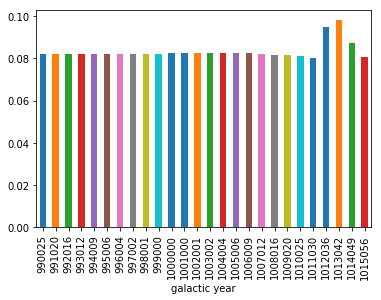

In [102]:
df.groupby('galactic year')['y'].mean().plot.bar()

In [110]:
final_test_df['galactic year'].value_counts()

1007012    90
1008016    90
1009020    90
1010025    90
1011030    90
1012036    89
1013042    89
1014049    89
1015056    87
1016064    86
Name: galactic year, dtype: int64

In [324]:
final_test_df['galactic year']  -= 990000
final_test_df['galactic year'].value_counts()

17012    90
18016    90
19020    90
20025    90
21030    90
22036    89
23042    89
24049    89
25056    87
26064    86
Name: galactic year, dtype: int64

### galaxy

In [22]:
df['galactic year'].isnull().sum()

0

In [640]:
df['galaxy'].value_counts()

Andromeda XXIV                                 26
Tucana Dwarf                                   26
Andromeda XXII[57]                             26
Andromeda XII                                  26
Andromeda XIX[60]                              26
Andromeda II                                   25
M32 (NGC 221)                                  25
Pisces IV (Andromeda XIV)                      25
Pisces II                                      25
Andromeda XXVIII                               25
Andromeda XV                                   25
IC 10 (UGC 192)                                25
Cetus Dwarf                                    25
Cassiopeia III (Andromeda XXXII)               25
Pegasus III                                    25
Leo IV Dwarf                                   25
Andromeda XXIII                                25
IC 1613 (UGC 668)                              25
Pisces V (Andromeda XVI)                       25
Canes Venatici II Dwarf                        25


In [193]:
set(df['galaxy'].unique()).difference(set(final_test_df['galaxy'].unique()))

{'Andromeda XII',
 'Andromeda XIX[60]',
 'Andromeda XVIII[60]',
 'Andromeda XXII[57]',
 'Andromeda XXIV',
 'Hercules Dwarf',
 'NGC 5253',
 'Triangulum Galaxy (M33)',
 'Tucana Dwarf'}

In [191]:
len(set(df['galaxy'].unique()).intersection(set(final_test_df['galaxy'].unique())))

172

In [192]:
final_test_df['galaxy'].unique().shape

(172,)

In [338]:
for i in df.itertuples():
    print(i._1)
    break

25


In [347]:
gm = GalaxyModels()
gm.fit(df)

In [351]:
gm.predict(df)

[0.05286888191759471,
 0.05995148786344227,
 0.05136880684749876,
 0.05026108155817566,
 0.13467518713073978,
 0.05315210842309502,
 0.05387338528122162,
 0.0636300322967278,
 0.0552635165717499,
 0.050561617712111435,
 0.06009577419047406,
 0.049707111097487044,
 0.175412199334972,
 0.15210436348073111,
 0.051202832677060474,
 0.09138594807569149,
 0.08349479527173517,
 0.05233091538666903,
 0.07194893727819725,
 0.059385646376000086,
 0.05391498471085805,
 0.0534433820655961,
 0.20788298936494962,
 0.07566817701848896,
 0.05145534621638587,
 0.05910721664080676,
 0.06319963331035823,
 0.056750183748496975,
 0.0893146481569673,
 0.15063480263089868,
 0.066568936363528,
 0.0534110947196444,
 0.057935710142411806,
 0.06680552013027924,
 0.07036212495607146,
 0.05392244514533494,
 0.05586745445104881,
 0.0519684418956931,
 0.05546918378975282,
 0.07949975063981479,
 0.14864541959599087,
 0.07717474525031356,
 0.04934959234785998,
 0.057258435962426246,
 0.11521951918703914,
 0.1691432279

In [325]:
galaxy = 'Triangulum Galaxy (M33)'
#HIZSS 003

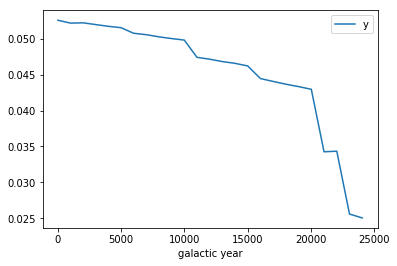

In [326]:
df[df['galaxy']==galaxy].sort_values('galactic year').plot.line(y='y',x='galactic year')

In [327]:
x_pl = np.hstack((df[df['galaxy']==galaxy]['galactic year'].values.reshape(-1,1)/27000,
                  (df[df['galaxy']==galaxy]['galactic year'].values.reshape(-1,1)/27000)**2,
                  (df[df['galaxy']==galaxy]['galactic year'].values.reshape(-1,1)/27000)**3))
# mm = MinMaxScaler()

# x_pl_scaled = mm.fit_transform(x_pl)
x_pl_scaled = x_pl

lr=LinearRegression()
#lr=Ridge(alpha=1)
lr.fit(x_pl_scaled,df[df['galaxy']==galaxy]['y'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

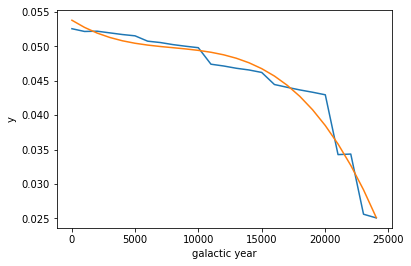

In [328]:
sns.lineplot(x=df[df['galaxy']==galaxy].sort_values('galactic year')['galactic year'],y=df[df['galaxy']==galaxy].sort_values('galactic year')['y'])
sns.lineplot(x=df[df['galaxy']==galaxy].sort_values('galactic year')['galactic year'],y=lr.predict(x_pl_scaled))

array([-218.04252233])

In [227]:
df[df['galaxy']==galaxy].sort_values('galactic year')

galactic year      galaxy  existence expectancy index  \
56    990025         Phoenix II  0.952909                     
270   991020         Phoenix II  0.837159                     
463   992016         Phoenix II  0.945129                     
640   993012         Phoenix II  0.910495                     
774   994009         Phoenix II  0.907358                     
1057  995006         Phoenix II  0.922333                     
1192  996004         Phoenix II  1.048018                     
1347  997002         Phoenix II  0.913094                     
1607  998001         Phoenix II  0.991251                     
1768  999000         Phoenix II  0.990636                     
1811  1000000        Phoenix II  0.946343                     
2021  1001000        Phoenix II  0.915324                     
2289  1002001        Phoenix II  1.061720                     
2358  1003002        Phoenix II  0.932590                     
2535  1004004        Phoenix II  1.005420                     
2855  1005006        Phoenix II  0.975695                     
2883  1006009        Phoenix II  0.890348                     
3661  1013042        Phoenix II  1.036667                     
3757  1014049        Phoenix II  0.904959                     

      existence expectancy at birth  Gross income per capita  Income Index  \
56    75.959963                      26557.505620             0.600758       
270   77.837553                      16247.327542             0.398875       
463   81.040479                      27888.188124             0.740773       
640   80.558419                      21514.149092             0.621758       
774   83.306536                      24177.876164             0.682266       
1057  78.393923                      10169.550893             0.630508       
1192  77.764968                      20006.045551             0.743408       
1347  73.282329                      16566.889143             0.611088       
1607  74.801871                      15294.276390             0.731983       
1768  81.720592                      21726.046755             0.684343       
1811  81.020079                      26436.072777             0.687468       
2021  76.013962                      27230.513015             0.711208       
2289  81.122327                      30325.806041             0.760372       
2358  80.004940                      28824.548403             0.836141       
2535  81.610418                      17392.017061             0.824472       
2855  88.841210                      21438.092977             0.887763       
2883  86.510301                      18484.905428             0.707419       
3661  80.686026                      34878.720462             0.969781       
3757  86.354594                      30703.894330             0.859733       

      Expected years of education (galactic years)  \
56    13.016121                                      
270   13.400326                                      
463   13.232279                                      
640   10.836925                                      
774   11.314557                                      
1057  13.675810                                      
1192  14.298199                                      
1347  12.277019                                      
1607  13.700708                                      
1768  11.163621                                      
1811  13.200704                                      
2021  14.534961                                      
2289  13.322914                                      
2358  13.663577                                      
2535  14.135750                                      
2855  13.514218                                      
2883  13.435681                                      
3661  16.460928                                      
3757  18.469249                                      

      Mean years of education (galactic years)  \
56    5.679798                                   
270

In [111]:
final_test_df['galaxy'].value_counts()

180    10
7      10
143    10
26     10
19     10
128    10
64     9 
103    9 
45     9 
99     9 
74     9 
116    8 
113    8 
75     8 
84     8 
85     8 
95     8 
1      8 
96     8 
97     8 
122    8 
98     8 
121    8 
68     8 
119    8 
104    8 
107    8 
108    8 
102    8 
5      8 
8      8 
37     8 
12     8 
18     8 
4      8 
21     8 
3      8 
28     8 
31     8 
34     8 
38     8 
61     8 
40     8 
41     8 
46     8 
49     8 
52     8 
54     8 
123    8 
58     8 
57     8 
0      8 
152    8 
174    8 
147    8 
161    8 
131    8 
148    8 
156    8 
168    8 
138    8 
154    8 
164    8 
36     7 
136    7 
47     7 
133    7 
50     7 
142    7 
23     7 
146    7 
145    7 
87     6 
39     6 
167    6 
169    6 
160    5 
69     5 
172    5 
81     5 
80     5 
78     5 
24     5 
149    5 
162    5 
25     5 
65     5 
59     5 
165    5 
55     5 
150    5 
91     5 
94     5 
92     5 
118    5 
117    5 
115    5 
127    5 
88     5 
93     5 


In [114]:
final_test_df['galaxy'].unique().shape

(172,)

In [121]:
len(set(df['galaxy'].unique()).intersection(set(final_test_df['galaxy'].unique())))

172

In [120]:
set(final_test_df['galaxy'].unique())

{'Andromeda Galaxy (M31)',
 'Andromeda I',
 'Andromeda II',
 'Andromeda III',
 'Andromeda IX',
 'Andromeda V',
 'Andromeda VIII',
 'Andromeda X',
 'Andromeda XI',
 'Andromeda XV',
 'Andromeda XVII',
 'Andromeda XX',
 'Andromeda XXIII',
 'Andromeda XXIX',
 'Andromeda XXI[57]',
 'Andromeda XXV',
 'Andromeda XXVI',
 'Andromeda XXVIII',
 'Antlia 2',
 'Antlia B',
 'Antlia Dwarf',
 'Aquarius Dwarf Galaxy (DDO 210)',
 'Aquarius II',
 "Barnard's Galaxy (NGC 6822)",
 'Boötes I',
 'Boötes II',
 'Boötes III',
 'Boötes IV',
 'Camelopardalis B',
 'Canes Venatici I Dwarf',
 'Canes Venatici II Dwarf',
 'Carina Dwarf (E206-G220)',
 'Carina II',
 'Carina III',
 'Cas 1 (KK98 19)',
 'Cassiopeia Dwarf (Cas dSph, Andromeda VII)',
 'Cassiopeia II (Andromeda XXX)',
 'Cassiopeia III (Andromeda XXXII)',
 'Cetus Dwarf',
 'Cetus III',
 'Columba I',
 'Coma Berenices Dwarf',
 'Crater II',
 'DDO 99 (UGC 6817)',
 'Donatiello I',
 'Draco Dwarf (DDO 208)',
 'Draco II',
 'Dwingeloo 1',
 'Dwingeloo 2',
 'ESO 274-01[70]'

### existence expectancy index

In [23]:
df['existence expectancy index'].isnull().sum()

1

In [28]:
df['existence expectancy index'].describe()

count    3864.000000
mean     0.872479   
std      0.162367   
min      0.227890   
25%      0.763027   
50%      0.907359   
75%      0.992760   
max      1.246908   
Name: existence expectancy index, dtype: float64

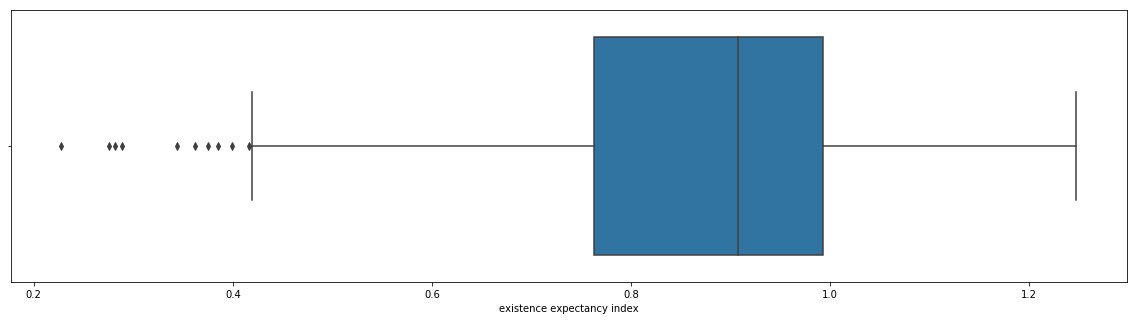

In [66]:
plt.figure(figsize=(20,5))
sns.boxplot(df['existence expectancy index'])

In [48]:

fill_median.append('existence expectancy index')

### existence expectancy at birth

In [31]:
df['existence expectancy at birth'].isnull().sum()

1

In [32]:
df['existence expectancy at birth'].describe()

count    3864.000000
mean     76.798111  
std      10.461654  
min      34.244062  
25%      69.961449  
50%      78.995101  
75%      84.558971  
max      100.210053 
Name: existence expectancy at birth, dtype: float64

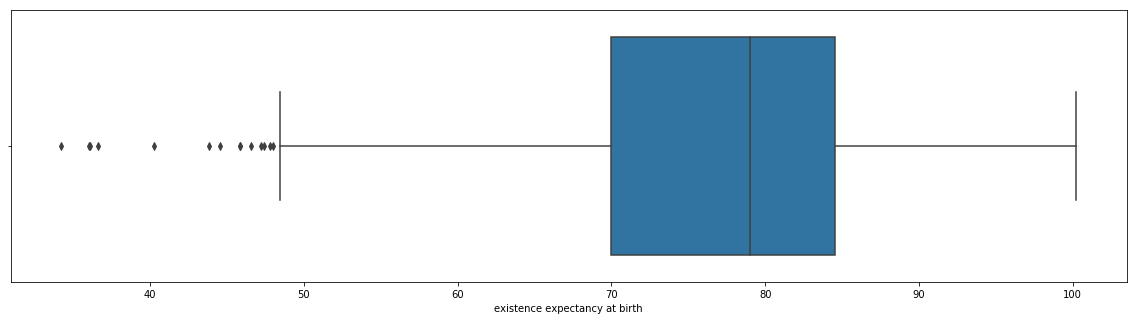

In [67]:
plt.figure(figsize=(20,5))
sns.boxplot(df['existence expectancy at birth'])

In [49]:

fill_median.append('existence expectancy at birth')

### Gross income per capita

In [72]:
df['Gross income per capita'].isnull().sum()

0

In [35]:
df['Gross income per capita'].describe()

count    3837.000000  
mean     31633.240872 
std      18736.378445 
min     -126.906522   
25%      20169.118912 
50%      26600.768195 
75%      36898.631754 
max      151072.683156
Name: Gross income per capita, dtype: float64

In [50]:
df = df[df['Gross income per capita']>0]

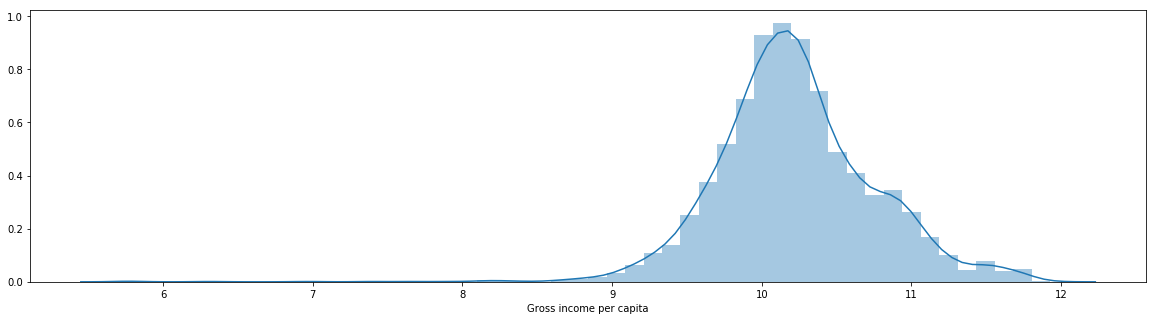

In [80]:
plt.figure(figsize=(20,5))
sns.distplot(df['Gross income per capita'])

In [51]:
#df['Gross income per capita'] = np.log1p(df['Gross income per capita'])
fill_median.append('Gross income per capita')

In [40]:
df[df['Gross income per capita']<0]

galactic year                    galaxy  existence expectancy index  \
3069  1007012        KUG 1210+301B (KK98 127)  0.842483                     

      existence expectancy at birth  Gross income per capita  Income Index  \
3069  78.180222                     -126.906522               0.56284        

      Expected years of education (galactic years)  \
3069  14.330079                                      

      Mean years of education (galactic years)  \
3069  7.091169                                   

      Intergalactic Development Index (IDI)  Education Index  \
3069  0.682565                               0.621393          

      Intergalactic Development Index (IDI), Rank  \
3069  207.410498                                    

      Population using at least basic drinking-water services (%)  \
3069  98.924591                                                     

      Population using at least basic sanitation services (%)  \
3069  73.895846                                                 

      Gross capital formation (% of GGP)  Population, total (millions)  \
3069  35.698449                          NaN                             

      Population, urban (%)  \
3069 NaN                      

      Mortality rate, under-five (per 1,000 live births)  \
3069 NaN                                                   

      Mortality rate, infant (per 1,000 live births)  \
3069 NaN                                               

      Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
3069 NaN                                                                                 

      Population, ages 15–64 (millions)  \
3069 NaN                                  

      Population, ages 65 and older (millions)  \
3069 NaN                                         

      Life expectancy at birth, male (galactic years)  \
3069 NaN                                                

      Life expectancy at birth, female (galactic years)  \
3069 NaN                                                  

      Population, under age 5 (millions)  \
3069 NaN                                   

      Young age (0-14) dependency ratio (per 100 creatures ages 15-64)  \
3069 NaN                                                                 

      Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
3069 NaN                                                                     

      Total unemployment rate (female to male ratio)  \
3069 NaN                                               

      Vulnerable employment (% of total employment)  \
3069 NaN                                              

      Unemployment, total (% of labour force)  \
3069 NaN                                        

      Employment in agriculture (% of total employment)  \
3069 NaN                                                  

      Labour force participation rate (% ages 15 and older)  \
3069 NaN                                                      

      Labour force participation rate (% ages 15 and older), female  \
3069 NaN                                                              

      Employment in services (% of total employment)  \
3069 NaN                                               

      Labour force participation rate (% ages 15 and older), male  \
3069 NaN                                                            

      Employment to population ratio (% ages 15 and older)  \
3069 NaN                                                     

      Jungle area (% of total land area)  \
3069 NaN                                   

      Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
3069 NaN                                                                                        

      Youth unemployment rate (female to male ratio)  \
3069 NaN                                               

      Unemployment, youth (% ages 15–24)  \
3069

### Income Index

In [38]:
df['Income Index'].isnull().sum()

28

In [39]:
df['Income Index'].describe()

count    3837.000000
mean     0.825154   
std      0.194055   
min      0.292001   
25%      0.677131   
50%      0.827300   
75%      0.970295   
max      1.361883   
Name: Income Index, dtype: float64

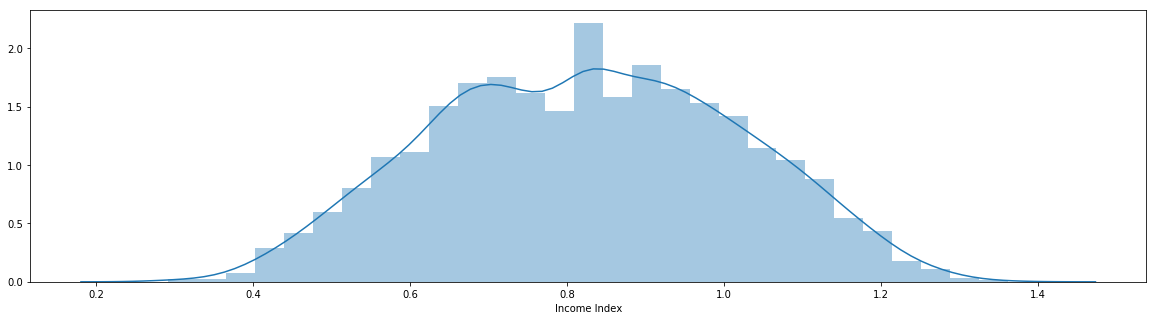

In [82]:
plt.figure(figsize=(20,5))
sns.distplot(df['Income Index'])

In [52]:

fill_median.append('Income Index')

### Expected years of education (galactic years)

In [84]:

df['Expected years of education (galactic years)'].isnull().sum()

133

In [85]:
df['Expected years of education (galactic years)'].describe()

count    3731.000000
mean     14.723402  
std      3.613025   
min      3.799663   
25%      12.592228  
50%      14.945667  
75%      17.123937  
max      26.955944  
Name: Expected years of education (galactic years), dtype: float64

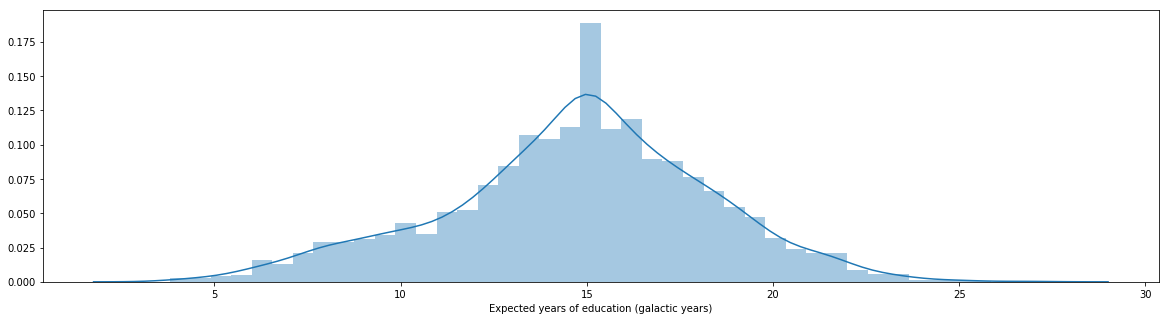

In [90]:
plt.figure(figsize=(20,5))
sns.distplot(df['Expected years of education (galactic years)'])

In [53]:
fill_median.append('Expected years of education (galactic years)')

### Mean years of education (galactic years)

In [91]:

df['Mean years of education (galactic years)'].isnull().sum()

363

In [92]:
df['Mean years of education (galactic years)'].describe()

count    3501.000000
mean     10.284871  
std      3.319983   
min      1.928166   
25%      7.661023   
50%      10.387326  
75%      12.885057  
max      19.057648  
Name: Mean years of education (galactic years), dtype: float64

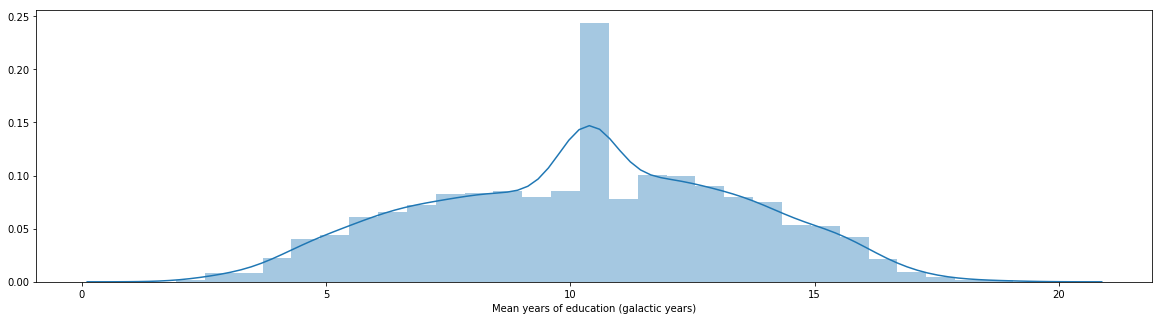

In [95]:
plt.figure(figsize=(20,5))
sns.distplot(df['Mean years of education (galactic years)'])

In [54]:
fill_median.append('Mean years of education (galactic years)')

In [108]:
spearmanr(df[df['Mean years of education (galactic years)'].isnull()==False]['Mean years of education (galactic years)'],
          df[df['Mean years of education (galactic years)'].isnull()==False]['Expected years of education (galactic years)'])[0]

0.7458928192400021

### Intergalactic Development Index (IDI)

In [55]:

df['Intergalactic Development Index (IDI)'].isnull().sum()

363

In [56]:
df['Intergalactic Development Index (IDI)'].describe()

count    3473.000000
mean     0.804281   
std      0.176256   
min      0.273684   
25%      0.671858   
50%      0.824836   
75%      0.939071   
max      1.232814   
Name: Intergalactic Development Index (IDI), dtype: float64

ValueError: cannot convert float NaN to integer

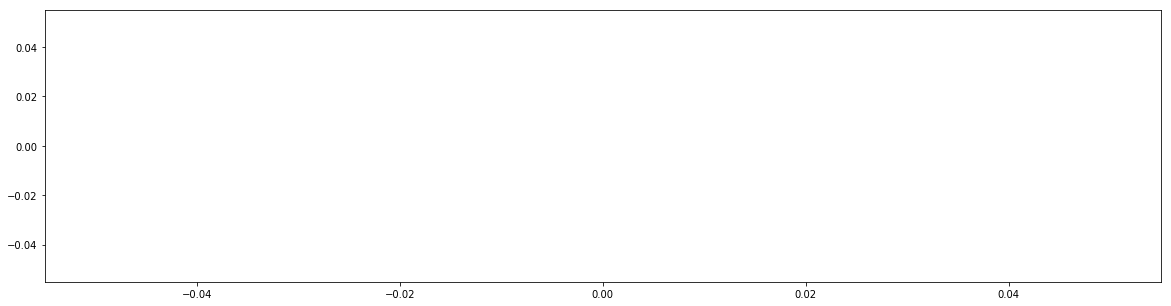

In [57]:
plt.figure(figsize=(20,5))
sns.distplot(df['Intergalactic Development Index (IDI)'])

In [58]:
fill_median.append('Intergalactic Development Index (IDI)')

### Education Index 

In [60]:

df['Education Index'].isnull().sum()

363

In [62]:
df['Education Index'].describe()

count    3473.000000
mean     0.745936   
std      0.199813   
min      0.189874   
25%      0.597730   
50%      0.761266   
75%      0.893539   
max      1.269625   
Name: Education Index, dtype: float64

ValueError: cannot convert float NaN to integer

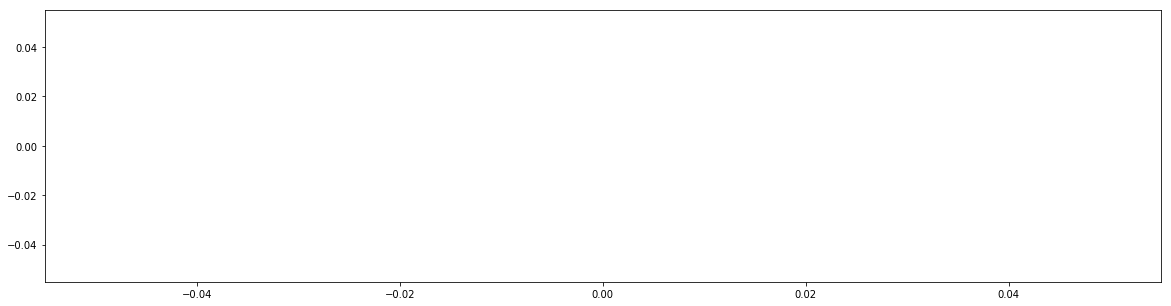

In [63]:
plt.figure(figsize=(20,5))
sns.distplot(df['Education Index'])

In [64]:
fill_median.append('Education Index')

### Intergalactic Development Index (IDI), Rank 

In [66]:

df['Intergalactic Development Index (IDI), Rank'].isnull().sum()

405

In [67]:
df['Intergalactic Development Index (IDI), Rank'].describe()

count    3431.000000
mean     135.108111 
std      52.442655  
min      9.925906   
25%      92.195295  
50%      135.904250 
75%      175.288264 
max      278.786613 
Name: Intergalactic Development Index (IDI), Rank, dtype: float64

ValueError: cannot convert float NaN to integer

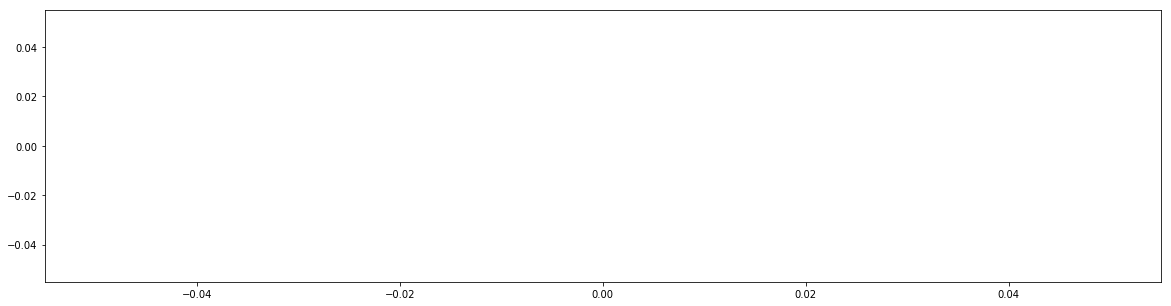

In [68]:
plt.figure(figsize=(20,5))
sns.distplot(df['Intergalactic Development Index (IDI), Rank'])

In [69]:
fill_median.append('Intergalactic Development Index (IDI), Rank')

### Population using at least basic drinking-water services (%) 

In [70]:

df['Population using at least basic drinking-water services (%)'].isnull().sum()

1816

In [71]:
df['Population using at least basic drinking-water services (%)'].describe()

count    2020.000000
mean     101.893707 
std      20.324784  
min      33.135967  
25%      89.466094  
50%      108.435114 
75%      116.911587 
max      136.321824 
Name: Population using at least basic drinking-water services (%), dtype: float64

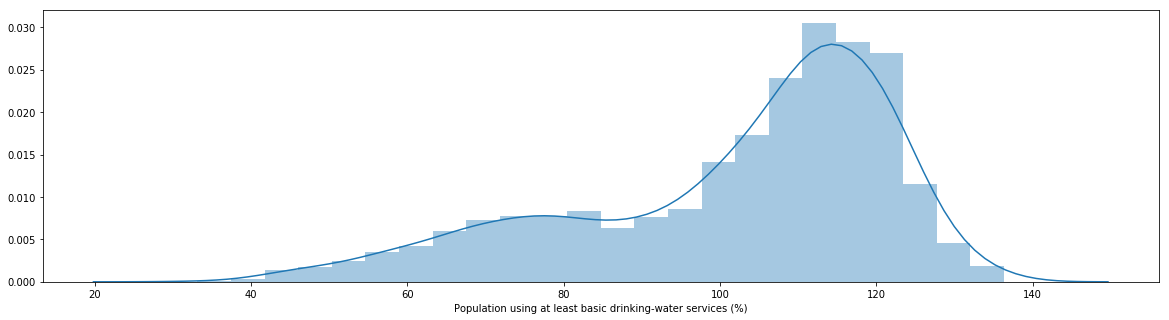

In [74]:
plt.figure(figsize=(20,5))
sns.distplot(df[df['Population using at least basic drinking-water services (%)'].isnull()==False]['Population using at least basic drinking-water services (%)'])



In [75]:
fill_median.append('Population using at least basic drinking-water services (%)')

### Population using at least basic sanitation services (%) 

In [78]:

df['Population using at least basic sanitation services (%)'].isnull().sum()

1822

In [79]:
df['Population using at least basic sanitation services (%)'].describe()

count    2014.000000
mean     99.949714  
std      32.367784  
min      10.609505  
25%      73.444386  
50%      110.286572 
75%      125.672824 
max      161.270978 
Name: Population using at least basic sanitation services (%), dtype: float64

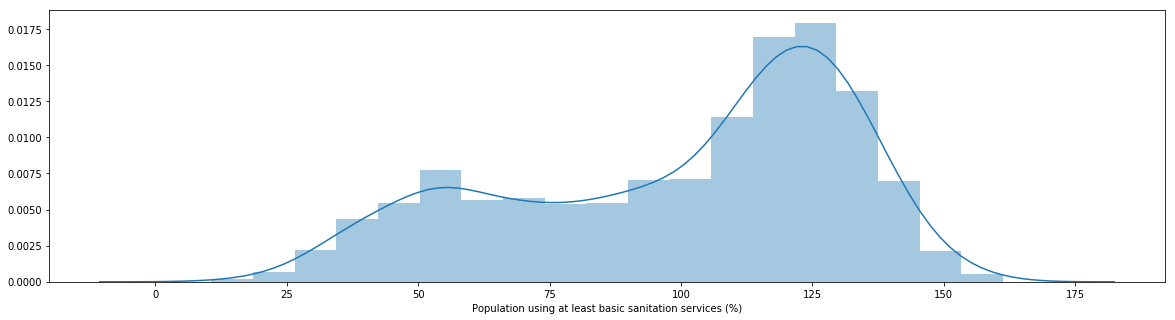

In [80]:
plt.figure(figsize=(20,5))
sns.distplot(df[df['Population using at least basic sanitation services (%)'].isnull()==False]['Population using at least basic sanitation services (%)'])


In [81]:
fill_median.append('Population using at least basic sanitation services (%)')

## redundant features


In [10]:
mask_df = df.corr().values
mask_df = np.where((mask_df>=0.7)|(mask_df<=-0.7),False,True)

In [6]:
mask_df[(mask_df>=0.7)|(mask_df<=-0.7)]=0
mask_df[(mask_df<0.7)&(mask_df>-0.7)]=1

In [456]:
# plt.figure(figsize=(60,60))
# sns.heatmap(df.corr(),mask=mask_df,annot=True)

In [13]:
new_mask_df_corr = df.corr().values
new_mask_df = np.argwhere((new_mask_df_corr>=0.7)|(new_mask_df_corr<=-0.7))

In [31]:
new_mask_df[new_mask_df[:,0]<new_mask_df[:,1]].shape

(397, 2)

In [29]:
new_mask_df.shape

(873, 2)

In [44]:
col_names = df.drop('galaxy',axis=1).columns

redundant_df = pd.DataFrame(new_mask_df[new_mask_df[:,0]<new_mask_df[:,1]]
                            ,columns=['corr_row','corr_col'])
redundant_df['name_r'] = redundant_df['corr_row'].apply(lambda x: col_names[x])
redundant_df['name_c'] = redundant_df['corr_col'].apply(lambda x: col_names[x])
redundant_df['corr'] = redundant_df[['corr_row','corr_col']].apply(lambda x: new_mask_df_corr[x.corr_row,x.corr_col],axis=1)
redundant_df[(~redundant_df['corr_row'].isin(ind_to_drop))&(~redundant_df['corr_col'].isin(ind_to_drop))]

corr_row  corr_col  \
0    1         2          
1    1         4          
2    1         5          
3    1         7          
5    1         9          
6    1         10         
7    1         11         
13   1         24         
18   1         52         
24   2         4          
25   2         5          
26   2         7          
28   2         9          
29   2         10         
30   2         11         
36   2         24         
42   2         52         
49   3         4          
53   4         5          
54   4         7          
56   4         9          
57   4         10         
58   4         11         
59   4         14         
76   5         6          
77   5         7          
79   5         9          
80   5         11         
95   6         7          
97   6         9          
98   6         11         
113  7         9          
114  7         10         
115  7         11         
121  7         24         
130  7         52         
135  7         67         
162  9         10         
163  9         11         
179  10        11         
188  10        52         
199  11        24         
205  11        52         
215  13        43         

                                                          name_r  \
0    existence expectancy index                                    
1    existence expectancy index                                    
2    existence expectancy index                                    
3    existence expectancy index                                    
5    existence expectancy index                                    
6    existence expectancy index                                    
7    existence expectancy index                                    
13   existence expectancy index                                    
18   existence expectancy index                                    
24   existence expectancy at birth                                 
25   existence expectancy at birth                                 
26   existence expectancy at birth                                 
28   existence expectancy at birth                                 
29   existence expectancy at birth                                 
30   existence expectancy at birth                                 
36   existence expectancy at birth                                 
42   existence expectancy at birth                                 
49   Gross income per capita                                       
53   Income Index                                                  
54   Income Index                                                  
56   Income Index                                                  
57   Income Index                                                  
58   Income Index                                                  
59   Income Index                                                  
76   Expected years of education (galactic years)                  
77   Expected years of education (galactic years)                  
79   Expected years of education (galactic years)                  
80   Expected years of education (galactic years)                  
95   Mean years of education (galactic years)                      
97   Mean years of education (galactic years)                      
98   Mean years of education (galactic years)                      
113  Intergalactic Development Index (IDI)                         
114  Intergalactic Development Index (IDI)                         
115  Intergalactic Development Index (IDI)                         
121  Intergalactic Development Index (IDI)                         
130  Intergalactic Development Index (IDI)                         
135  Intergalactic Development Index (IDI)                         
162  Intergalactic Development Index (IDI), Rank                   
163  Intergalactic Development Index (IDI), Rank                   
179  Population using at least basic drinking-water services (%)   
1

In [683]:
columns_to_drop = ['Life expectancy at birth, male (galactic years)',
                 'Life expectancy at birth, female (galactic years)',
                  'Intergalactic Development Index (IDI), female',
                   'Intergalactic Development Index (IDI), male',
                   'Mortality rate, under-five (per 1,000 live births)',
                   'Mortality rate, infant (per 1,000 live births)',
                 'Mortality rate, female grown up (per 1,000 people)',
                   'Mortality rate, male grown up (per 1,000 people)',
                   'Gross galactic product (GGP) per capita',
                   'Estimated gross galactic income per capita, male',
                   'Estimated gross galactic income per capita, female',
                   'Intergalactic Development Index (IDI), female, Rank',
                   'Intergalactic Development Index (IDI), male, Rank',
                   
                   'Expected years of education, female (galactic years)',
                   'Expected years of education, male (galactic years)',
                   'Mean years of education, female (galactic years)',
                   'Mean years of education, male (galactic years)',
                   
                   'Population with at least some secondary education, female (% ages 25 and older)',
                   'Population with at least some secondary education, male (% ages 25 and older)',
                   'Population with at least some secondary education (% ages 25 and older)',
                   'Young age (0-14) dependency ratio (per 100 creatures ages 15-64)',
                   'Vulnerable employment (% of total employment)',
                   
                   'Employment in agriculture (% of total employment)',
                   'Gender Inequality Index (GII)',
                   'Education Index',
                   'Rural population with access to electricity (%)',
                   
                   'Gross fixed capital formation (% of GGP)',
                   
                   'Population, ages 15–64 (millions)',
                   'Population, ages 65 and older (millions)',
                   'Population, under age 5 (millions)',
                   'Intergalactic inbound tourists (thousands)',
                   
                   'Employment in services (% of total employment)',
                   'Youth unemployment rate (female to male ratio)',
                   'Unemployment, youth (% ages 15–24)',
                   'Labour force participation rate (% ages 15 and older), female',
                   'Employment to population ratio (% ages 15 and older)',
                   
                   'Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)'
                                                    
                  ]

ind_to_drop = [20,21,69,70,15,16,38,39,42,54,55,72,73,50,51,48,49,58,59,62,23,26,
                28,77,8,56,
               60,18,19,22,63,
              31,36,37,30,33,
              41,63] #

len(ind_to_drop)

38

In [ ]:
Intergalactic Development Index (IDI)  Employment in services (% of total employment)  74  0.762034

Intergalactic Development Index (IDI), Rank    Employment in agriculture (% of total employment) 86  0.72

Population using at least basic drinking-water services (%)   Employment in agriculture (% of total employment)   370 0.72
Population using at least basic drinking-water services (%)  Rural population with access to electricity (%)   188  0.79

Population using at least basic sanitation services (%)   Maternal mortality ratio (deaths per 100,000 live births)  376. 0.72

Population, urban (%)    Employment in services (% of total employment)  176  0.72

Labour force participation rate (% ages 15 and older)   Employment to population ratio (% ages 15 and older)  177 0.85

Gross galactic product (GGP), total Intergalactic inbound tourists (thousands)  28  0.86

In [18]:
#df[(df['Mean years of education (galactic years)'].isnull())].count()

In [41]:
df[(df['Gross galactic product (GGP), total'].isnull())][[
    'Intergalactic inbound tourists (thousands)',

 
]].count()

Intergalactic inbound tourists (thousands)    28
dtype: int64

## Changing dfs


In [684]:
#df = df[df['Gross income per capita']>0]
#df['Gross income per capita'] = np.log1p(df['Gross income per capita'])
df['galactic year'] = df['galactic year']-990000
final_test_df['galactic year'] = final_test_df['galactic year']-990000

full_df['galactic year'] = full_df['galactic year']-990000

In [685]:
df = df.drop(columns_to_drop,axis=1)
final_test_df = final_test_df.drop(columns_to_drop,axis=1)

full_df = full_df.drop(columns_to_drop,axis=1)

In [686]:
df = df.drop(df[df['galaxy']=='NGC 5253'].index)
final_test_df = final_test_df.drop(final_test_df[final_test_df['galaxy']=='NGC 5253'].index)

full_df = full_df.drop(full_df[full_df['galaxy']=='NGC 5253'].index)

In [688]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 0 to 4754
Data columns (total 43 columns):
galactic year                                                                              4754 non-null int64
galaxy                                                                                     4754 non-null object
existence expectancy index                                                                 4749 non-null float64
existence expectancy at birth                                                              4749 non-null float64
Gross income per capita                                                                    4721 non-null float64
Income Index                                                                               4721 non-null float64
Expected years of education (galactic years)                                               4617 non-null float64
Mean years of education (galactic years)                                                   4384 non-null 

## Filling nulls

In [690]:
full_df[full_df['galaxy']=='Cetus III']

galactic year     galaxy  existence expectancy index  \
79    25             Cetus III  0.878199                     
239   1020           Cetus III  0.808467                     
439   2016           Cetus III  0.739820                     
586   3012           Cetus III  0.769406                     
815   4009           Cetus III  0.822276                     
1051  5006           Cetus III  0.745999                     
1200  6004           Cetus III  0.712382                     
1291  7002           Cetus III  0.653539                     
1516  8001           Cetus III  0.614143                     
1634  9000           Cetus III  0.630306                     
1885  10000          Cetus III  0.493076                     
2080  11000          Cetus III  0.542562                     
2231  12001          Cetus III  0.518152                     
2342  13002          Cetus III  0.431251                     
2691  14004          Cetus III  0.547139                     
2834  15006          Cetus III  0.428182                     
2952  16009          Cetus III  0.465843                     
3135  17012          Cetus III  0.504694                     
3199  18016          Cetus III  0.532587                     
3261  19020          Cetus III  0.553055                     
3402  20025          Cetus III  0.557174                     
3469  21030          Cetus III  0.576359                     
3579  22036          Cetus III  0.555019                     
3620  23042          Cetus III  0.659265                     
3777  24049          Cetus III  0.714888                     
3890  25056          Cetus III  0.638718                     
3953  26064          Cetus III  0.732327                     

      existence expectancy at birth  Gross income per capita  Income Index  \
79    71.647289                      22565.234229             0.853650       
239   70.609864                      23401.297941             0.705716       
439   66.380609                      20324.215791             0.736071       
586   75.611159                      29219.991422             0.827668       
815   72.660805                      17201.076333             0.756610       
1051  64.462094                      22631.965509             0.872393       
1200  62.297052                      14109.106192             0.771251       
1291  62.716777                      30506.127891             0.875331       
1516  55.606169                      23992.951303             0.700331       
1634  59.105096                      32425.914657             0.703302       
1885  58.745542                      15454.311593             0.813354       
2080  59.692337                      31802.655063             0.882905       
2231  57.903985                      16636.176230             0.795040       
2342  48.443792                      17082.917747             0.951278       
2691  53.110948                      21783.799665             0.895328       
2834  52.681589                      23365.111942             0.753312       
2952  55.051583                      24378.481901             0.850562       
3135  50.000754                      28456.322122             0.815957       
3199  54.745120                      33333.099409             0.816650       
3261  53.515622                      18861.010900             0.888790       
3402  58.218334                      21387.197111             0.866619       
3469  49.560998                      28347.482559             0.898933       
3579  54.189461                      27207.582812             0.885533       
3620  69.152095                      27116.541714             0.816593       
3777  63.081069                      13803.909622             0.886664       
3890  63.680362                      17525.506529             0.902930       
3953  71.532674                      33360.840015             0.825167       

      Expected years of education (galactic years)  \
79    13.537104               

In [691]:
class GalaxyFillingModels():
    def __init__(self):
        self.models_d = {}

        self.full_df = None
        self.full_df2 = None
        
    def fit(self,df, cols_to_fill, gal_median_d):
        
        self.full_df = df.copy()
        for col2 in self.full_df.columns:
                self.full_df[col2] = self.full_df[col2].fillna(self.full_df[col2].mean())                
        
        mm = MinMaxScaler()
        sfdf_ind = self.full_df.index
        sfdf_cols = self.full_df.columns
        self.full_df = pd.DataFrame(mm.fit_transform(self.full_df),index=sfdf_ind,columns=sfdf_cols)
        #print(self.full_df)
        
        for col in cols_to_fill:
            #print(col)
            fill_f_df = df[df[col].isnull()==False]
            indxs = fill_f_df.index
            
            fill_train = self.full_df.loc[indxs,:].drop(col,axis=1)
            fill_y = fill_f_df[col]
            #print(fill_y)
            x_pl = fill_train.values
            #print(x_pl)
            #print(x_pl.shape)
            lr=LinearRegression()
            #lr=Ridge()
            lr.fit(x_pl,
                   fill_y)
            
            self.models_d[col] = pickle.dumps(lr)
            
    def predict(self,
                X_test,
                cols_to_fill):
        res_df = X_test.copy()
        #print(self.models_d.keys())    
        for col in cols_to_fill:
            
            col_ser = X_test.isnull().loc[:,col]
            null_indxs = col_ser[col_ser==True].index
            #print(col)
            #print(null_indxs)
            X_pred = self.full_df.loc[null_indxs,:].drop(col,axis=1)
                
            lr = pickle.loads(self.models_d[col])
            
            x_pl = X_pred.values
            
            col_result = lr.predict(x_pl)
            #print(col , col_result)
            
            res_df.loc[null_indxs,col] = col_result

        return res_df


def fill_cols_nulls_mean(nparr):

    first_el = None
    last_el = 0
    replace_indxs = []
    
    res_arr = nparr.copy()
    
    for ind,i in enumerate(nparr):
        
        if (np.isnan(i)==False) and (len(replace_indxs)==0):
            first_el = i
            continue
        if (np.isnan(i)==False) and (len(replace_indxs)>0):
            last_el = i
            if first_el is None:
                res_arr[replace_indxs] = last_el
            else:
                res_arr[replace_indxs] = np.mean([first_el,last_el])          
            first_el = last_el
            last_el = 0
            replace_indxs = []
            continue
            
        replace_indxs.append(ind)
        
        if (ind == len(nparr)-1) and (len(replace_indxs)>0):
            res_arr[replace_indxs] = first_el
        
    if (np.isnan(res_arr[0])):
        print('first element is nan')
    if ( np.isnan(res_arr[-1])):
        print('last element is nan')
        
    return res_arr
    

def fill_full_galaxies_df(df):   

    
    gal_median_d = {}
    for col in df.drop(['galactic year','galaxy'],axis=1).columns:
        gal_median_d[col] = df[col].median(skipna=True)
        
    #print(gal_median_d)
    all_galaxies = df['galaxy'].unique()
    print('all_galaxies = ',len(all_galaxies))
    all_dfs = []
    
    for gal in tqdm_notebook(all_galaxies):
        start_time = time.time()
        print('galaxy ',gal)
        gal_df = df[df['galaxy']==gal].sort_values('galactic year')
              
        
        all_nulls_cols = (gal_df.isnull().sum() ==  gal_df.shape[0])
        all_nulls_cols = all_nulls_cols[all_nulls_cols==True].index
        print('all null cols =', list(all_nulls_cols))
        for col2 in all_nulls_cols:
                gal_df[col2] = gal_df[col2].fillna(gal_median_d[col2])
        
        
        right_rows = (gal_df.isnull().sum(axis=1))
        right_inds = right_rows[(right_rows<right_rows.mean())==True].index
        #print(right_inds)
        cols_to_model_fill = gal_df.isnull().loc[right_inds,:].sum() > 0
        cols_to_model_fill = cols_to_model_fill[cols_to_model_fill==True].index
        #print(cols_to_model_fill)
        #print('start model' , time.time()-start_time)
        gfm = GalaxyFillingModels()
        gfm.fit(
            gal_df.loc[right_inds,:].drop('galaxy',axis=1),
            cols_to_model_fill,
            gal_median_d
        )
        gfm_pred = gfm.predict(
            gal_df.loc[right_inds,:],
            cols_to_model_fill
        )
        #print('start =' , time.time()-start_time)
        gal_df.loc[right_inds,cols_to_model_fill]=gfm_pred.loc[right_inds,cols_to_model_fill].values
          
        cols_to_fill_nulls = gal_df.isnull().sum() > 0
        indx_cols_to_fill_nulls = np.nonzero(cols_to_fill_nulls.values)[0]
        cols_to_fill_nulls = cols_to_fill_nulls[cols_to_fill_nulls==True].index

#         for col in tqdm_notebook(cols_to_fill_nulls):
#             gal_df.loc[:,col] = fill_cols_nulls_mean(gal_df.loc[:,col].values)
        #print('start nulls' , time.time()-start_time)   
        filled_cols = np.vstack([fill_cols_nulls_mean(gal_df.loc[:,col].values) for col in cols_to_fill_nulls]).T
        
        
#         pool = Pool(6)
#         filled_cols = pool.map(fill_cols_nulls_mean, [gal_df.loc[:,col].values for col in cols_to_fill_nulls])
#         pool.close()
#         pool.join()      
        #print('end nulls' , time.time()-start_time)
    
        gal_df_np = gal_df.values
        gal_df_index = gal_df.index
        gal_df_cols = gal_df.columns

        gal_df_np[:,indx_cols_to_fill_nulls] = filled_cols
        gal_df = pd.DataFrame(gal_df_np,index = gal_df_index,columns=gal_df_cols)
        
        #print('end loc' , time.time()-start_time)
        
        all_dfs.append(gal_df)
        print('-------------------')
        
    return pd.concat(all_dfs)
        

In [692]:
f_check = np.array([ np.nan, 27., np.nan,np.nan, np.nan,
       28., np.nan,np.nan, np.nan, np.nan,
       30., np.nan, np.nan, np.nan, np.nan,
       36., np.nan, np.nan, np.nan, np.nan,
       34., 35., 33., 30. , 31.])
f_true = np.array([27. , 27. , 27.5, 27.5, 27.5, 28. , 29. , 29. , 29. , 29. , 30. ,
       33. , 33. , 33. , 33. , 36. , 35. , 35. , 35. , 35. , 34. , 35. ,
       33. , 30. , 31. ])

s_check = np.array([ np.nan,np.nan, 27., np.nan,np.nan, np.nan,
       28., np.nan,np.nan, np.nan, np.nan,
       30., np.nan, np.nan, np.nan, np.nan,
       36., np.nan, np.nan, np.nan, np.nan,
       34., 35., 33., 30. , 31.])

s_true = np.array([27., 27. , 27. , 27.5, 27.5, 27.5, 28. , 29. , 29. , 29. , 29. , 30. ,
       33. , 33. , 33. , 33. , 36. , 35. , 35. , 35. , 35. , 34. , 35. ,
       33. , 30. , 31. ])

t_check = np.array([ 35, 27., np.nan,np.nan, np.nan,
       28., np.nan,np.nan, 40, np.nan,
       30., np.nan, np.nan, np.nan, np.nan,
       36., np.nan, np.nan, np.nan, np.nan,
       34., 35., 33., 30. , 31.])

t_true = np.array([35. , 27. , 27.5, 27.5, 27.5, 28. , 34. , 34. , 40. , 35. , 30. ,
       33. , 33. , 33. , 33. , 36. , 35. , 35. , 35. , 35. , 34. , 35. ,
       33. , 30. , 31. ])

fourth_check = np.array([ 35, 27., np.nan,np.nan, np.nan,
       28., np.nan,np.nan, 40, np.nan,
       30., np.nan, np.nan, np.nan, np.nan,
       36., np.nan, np.nan, np.nan, np.nan,
       34., 35., 33., np.nan , np.nan])

fourth_true = np.array([35. , 27. , 27.5, 27.5, 27.5, 28. , 34. , 34. , 40. , 35. , 30. ,
       33. , 33. , 33. , 33. , 36. , 35. , 35. , 35. , 35. , 34. , 35. ,
       33. , 33. , 33. ])

fifth_check = np.array([ np.nan, 27., np.nan,np.nan, np.nan,
       28., np.nan,np.nan, 40, np.nan,
       30., np.nan, np.nan, np.nan, np.nan,
       36., np.nan, np.nan, np.nan, np.nan,
       34., 35., 33., np.nan , np.nan])

fifth_true = np.array([27. , 27. , 27.5, 27.5, 27.5, 28. , 34. , 34. , 40. , 35. , 30. ,
       33. , 33. , 33. , 33. , 36. , 35. , 35. , 35. , 35. , 34. , 35. ,
       33. , 33. , 33. ])

assert np.all(fill_cols_nulls_mean(f_check) == f_true)
assert np.all(fill_cols_nulls_mean(s_check) == s_true)
assert np.all(fill_cols_nulls_mean(t_check) == t_true)
assert np.all(fill_cols_nulls_mean(fourth_check) == fourth_true)
assert np.all(fill_cols_nulls_mean(fifth_check) == fifth_true)


In [63]:
#Phoenix Dwarf Galaxy (P 6830)
#['Pegasus III','Phoenix Dwarf Galaxy (P 6830)','UGC 8651 (DDO 181)','Aquarius II']
filled_df = fill_full_galaxies_df(df)

all_galaxies =  180


galaxy  Large Magellanic Cloud (LMC)
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total', 'Private galaxy capital flows (% of GGP)']
-------------------
galaxy  Camelopardalis B
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']
-------------------
galaxy  Virgo I
all null cols = ['Private galaxy capital flows (% of GGP)']
-------------------
galaxy  UGC 8651 (DDO 181)
all null cols = ['Jungle area (% of total land area)', 'Current health expenditure (% of GGP)', 'Adjusted net savings ', 'Private galaxy capital flows (% of GGP)']
-------------------
galaxy  Tucana Dwarf
all null cols = []
-------------------
galaxy  KKh 060
all null cols = []
-------------------
galaxy  Grus II
all null cols = []
-------------------
galaxy  UGCA 292
all null cols = []
-------------------
galaxy  Aquarius II
all null cols = []
-------------------
galaxy  Andromeda XI
all null cols = ['Private galaxy capital flows (% of G

-------------------
galaxy  Tucana II
all null cols = ['Gross enrolment ratio, primary (% of primary under-age population)', 'Adjusted net savings ', 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']
-------------------
galaxy  Pisces I
all null cols = []
-------------------
galaxy  Cetus III
all null cols = []
-------------------
galaxy  UGC 7577 (DDO 125)
all null cols = ['Domestic credit provided by financial sector (% of GGP)']
-------------------
galaxy  HIPASS J1247-77
all null cols = ['Gross galactic product (GGP), total', 'Adjusted net savings ', 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total', 'Private galaxy capital flows (% of GGP)']
-------------------
galaxy  Triangulum Galaxy (M33)
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']
-------------------
galaxy  Small Magellanic Cloud (SMC, NGC 292)
all null cols = []
-------------------
galaxy  Canes Venatici I Dwarf
all null c

-------------------
galaxy  UGC 4483
all null cols = []
-------------------
galaxy  KKH 12
all null cols = []
-------------------
galaxy  Andromeda XXIX
all null cols = ['Private galaxy capital flows (% of GGP)']
-------------------
galaxy  Andromeda VIII
all null cols = []
-------------------
galaxy  Ursa Major II Dwarf
all null cols = []
-------------------
galaxy  Hydrus I
all null cols = []
-------------------
galaxy  MB 3
all null cols = ['Remittances, inflows (% of GGP)', 'Gross enrolment ratio, primary (% of primary under-age population)']
-------------------
galaxy  HIZSS 003
all null cols = []
-------------------
galaxy  Andromeda XXIII
all null cols = []
-------------------
galaxy  Cetus Dwarf
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']
-------------------
galaxy  Dwingeloo 2
all null cols = []
-------------------
galaxy  ESO 294-010
all null cols = []
-------------------
galaxy  Boötes II
all null cols = []
------------------

In [695]:
filled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 0 to 3610
Data columns (total 43 columns):
galactic year                                                                              3864 non-null object
galaxy                                                                                     3864 non-null object
existence expectancy index                                                                 3864 non-null object
existence expectancy at birth                                                              3864 non-null object
Gross income per capita                                                                    3864 non-null object
Income Index                                                                               3864 non-null object
Expected years of education (galactic years)                                               3864 non-null object
Mean years of education (galactic years)                                                   3864 non-null obje

In [170]:

df_no_nulls = filled_df.copy()

df_no_nulls['galactic year'] = df_no_nulls['galactic year'].astype('int')
for col in df_no_nulls.iloc[:,2:].columns:
    df_no_nulls[col] = df_no_nulls[col].astype('float')

In [171]:
filled_df[filled_df['galaxy']=='Aquarius II']

galactic year       galaxy existence expectancy index  \
8     25            Aquarius II  0.657402                    
260   1020          Aquarius II  0.696253                    
518   2016          Aquarius II  0.617739                    
702   3012          Aquarius II  0.571673                    
866   4009          Aquarius II  0.608791                    
928   5006          Aquarius II  0.60038                     
1086  6004          Aquarius II  0.678238                    
1429  7002          Aquarius II  0.683688                    
1556  8001          Aquarius II  0.725369                    
1695  9000          Aquarius II  0.613529                    
1961  10000         Aquarius II  0.668869                    
2104  11000         Aquarius II  0.605476                    
2313  12001         Aquarius II  0.660266                    
2405  13002         Aquarius II  0.747738                    
2637  14004         Aquarius II  0.725301                    
2838  15006         Aquarius II  0.712773                    
2976  16009         Aquarius II  0.816668                    
3062  17012         Aquarius II  0.742227                    
3207  18016         Aquarius II  0.78437                     
3250  19020         Aquarius II  0.795447                    
3399  20025         Aquarius II  0.82863                     
3502  21030         Aquarius II  0.786587                    
3588  22036         Aquarius II  0.731868                    
3859  25056         Aquarius II  0.751303                    

     existence expectancy at birth Gross income per capita Income Index  \
8     61.3371                       18231                   0.826377      
260   63.5839                       19071.4                 0.844641      
518   64.1122                       31714.7                 0.75601       
702   68.5053                       23365.8                 0.825493      
866   61.4314                       27404.6                 0.836875      
928   59.5477                       23782.9                 0.70182       
1086  59.3083                       15614.4                 0.82327       
1429  55.1984                       17973.2                 0.787017      
1556  61.7135                       17268.7                 0.764784      
1695  58.2118                       34685.5                 0.745394      
1961  64.9471                       29717.6                 0.657748      
2104  67.0621                       26071.2                 0.74968       
2313  63.2249                       20757                   0.724084      
2405  69.0707                       32315                   0.725779      
2637  63.5677                       21010.3                 0.631238      
2838  61.4359                       17398.2                 0.823587      
2976  71.6616                       3692.93                 0.590565      
3062  71.0176                       29524.7                 0.789303      
3207  68.5251                       18361                   0.744071      
3250  67.6704                       16020.4                 0.759275      
3399  67.062                        27538.3                 0.738357      
3502  73.939                        30500.5                 0.691836      
3588  74.5923                       23103.6                 0.844285      
3859  74.1139                       20552.7                 0.886003      

     Expected years of education (galactic years)  \
8     15.1733                                       
260   16.1021                                       
518   14.5316                                       
702   14.8349                                       
866   13.1494                                       
928   13.0006                                       
1086  14.0925                                       
1429  11.4117                                       
1556  12.8672                                       
1695  12.3223                                   

In [697]:
#df[df['galaxy']=='Pegasus III']

### full df

In [694]:
filled_full_df = fill_full_galaxies_df(full_df)

all_galaxies =  180


galaxy  Large Magellanic Cloud (LMC)
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total', 'Private galaxy capital flows (% of GGP)']
-------------------
galaxy  Camelopardalis B
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']
-------------------
galaxy  Virgo I
all null cols = ['Private galaxy capital flows (% of GGP)']
-------------------
galaxy  UGC 8651 (DDO 181)
all null cols = ['Jungle area (% of total land area)', 'Current health expenditure (% of GGP)', 'Adjusted net savings ', 'Private galaxy capital flows (% of GGP)']
-------------------
galaxy  Tucana Dwarf
all null cols = []
-------------------
galaxy  KKh 060
all null cols = []
-------------------
galaxy  Grus II
all null cols = []
-------------------
galaxy  UGCA 292
all null cols = []
-------------------
galaxy  Aquarius II
all null cols = []
-------------------
galaxy  Andromeda XI
all null cols = ['Private galaxy capital flows (% of G

-------------------
galaxy  Pisces I
all null cols = []
-------------------
galaxy  Cetus III
all null cols = []
-------------------
galaxy  UGC 7577 (DDO 125)
all null cols = []
-------------------
galaxy  HIPASS J1247-77
all null cols = ['Gross galactic product (GGP), total', 'Adjusted net savings ', 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total', 'Private galaxy capital flows (% of GGP)']
-------------------
galaxy  Triangulum Galaxy (M33)
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']
-------------------
galaxy  Small Magellanic Cloud (SMC, NGC 292)
all null cols = []
-------------------
galaxy  Canes Venatici I Dwarf
all null cols = []
-------------------
galaxy  UGCA 92
all null cols = []
-------------------
galaxy  IC 342
all null cols = ['Gross capital formation (% of GGP)', 'Exports and imports (% of GGP)', 'Adjusted net savings ']
-------------------
galaxy  UGC 4879 (VV124)[61]
all null cols = []
---

-------------------
galaxy  Andromeda XXIX
all null cols = []
-------------------
galaxy  Andromeda VIII
all null cols = []
-------------------
galaxy  Ursa Major II Dwarf
all null cols = []
-------------------
galaxy  Hydrus I
all null cols = []
-------------------
galaxy  MB 3
all null cols = ['Remittances, inflows (% of GGP)']
-------------------
galaxy  HIZSS 003
all null cols = []
-------------------
galaxy  Andromeda XXIII
all null cols = []
-------------------
galaxy  Cetus Dwarf
all null cols = ['Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']
-------------------
galaxy  Dwingeloo 2
all null cols = []
-------------------
galaxy  ESO 294-010
all null cols = []
-------------------
galaxy  Boötes II
all null cols = []
-------------------
galaxy  ESO 383-087 (ISG 39)
all null cols = ['Gross capital formation (% of GGP)', 'Exports and imports (% of GGP)', 'Adjusted net savings ', 'Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total']

In [699]:
filled_full_df[filled_full_df['galaxy']=='Reticulum III']

galactic year         galaxy existence expectancy index  \
172   25            Reticulum III  0.522122                    
330   1020          Reticulum III  0.543908                    
528   2016          Reticulum III  0.603091                    
610   3012          Reticulum III  0.480042                    
869   4009          Reticulum III  0.487961                    
1007  5006          Reticulum III  0.569395                    
1173  6004          Reticulum III  0.611309                    
1304  7002          Reticulum III  0.658729                    
1606  8001          Reticulum III  0.540846                    
1700  9000          Reticulum III  0.50984                     
1803  10000         Reticulum III  0.608963                    
2050  11000         Reticulum III  0.55201                     
2317  12001         Reticulum III  0.517443                    
2357  13002         Reticulum III  0.628353                    
2694  14004         Reticulum III  0.584344                    
2835  15006         Reticulum III  0.615729                    
3014  16009         Reticulum III  0.61488                     
3866  17012         Reticulum III  0.529835                    
3867  18016         Reticulum III  0.560976                    
3883  19020         Reticulum III  0.625082                    
3902  20025         Reticulum III  0.656685                    
3871  21030         Reticulum III  0.589852                    
3891  22036         Reticulum III  0.641159                    
3605  23042         Reticulum III  0.653825                    
3754  24049         Reticulum III  0.656292                    
3899  25056         Reticulum III  0.650696                    

     existence expectancy at birth Gross income per capita Income Index  \
172   56.7303                       24900.3                 0.533632      
330   59.5434                       19692.9                 0.500455      
528   52.5786                       9106.96                 0.569982      
610   54.1457                       26787.5                 0.537528      
869   59.3873                       17051.7                 0.640835      
1007  56.4021                       17575.8                 0.489286      
1173  52.0492                       6478.72                 0.587405      
1304  54.9156                       20244.6                 0.500271      
1606  59.2474                       25723.3                 0.550751      
1700  57.0688                       12407.8                 0.565098      
1803  52.4448                       24968.5                 0.529307      
2050  62.4097                       3337.89                 0.632476      
2317  61.7381                       24766.6                 0.487685      
2357  62.462                        16330.1                 0.519319      
2694  53.4272                       19102.3                 0.4726        
2835  54.478                        24982.4                 0.605094      
3014  59.2579                       16346.8                 0.622359      
3866  57.2283                       3431.88                 0.675407      
3867  59.3795                       27562.9                 0.594624      
3883  59.7225                       23405.4                 0.553998      
3902  57.4228                       16237.2                 0.749375      
3871  65.9296                       13188.1                 0.618425      
3891  64.5839                       16521.6                 0.635033      
3605  58.4513                       11481.3                 0.648924      
3754  58.9054                       23112.3                 0.637212      
3899  61.4386                       18152.8                 0.60977       

     Expected years of education (galactic years)  \
172   7.08017                                       
330   6.90436                                       
528   7.15564                                       
610   6.23901                         

In [701]:
full_df_no_nulls = filled_full_df.copy()

full_df_no_nulls['galactic year'] = full_df_no_nulls['galactic year'].astype('int')
for col in full_df_no_nulls.iloc[:,2:].columns:
    full_df_no_nulls[col] = full_df_no_nulls[col].astype('float')

## Fill with median

In [82]:
fill_median

['existence expectancy index',
 'existence expectancy at birth',
 'Gross income per capita',
 'Income Index',
 'Expected years of education (galactic years)',
 'Mean years of education (galactic years)',
 'Intergalactic Development Index (IDI)',
 'Education Index',
 'Intergalactic Development Index (IDI), Rank',
 'Population using at least basic drinking-water services (%)',
 'Population using at least basic sanitation services (%)']

In [380]:
fill_median = ['existence expectancy index',
 'existence expectancy at birth',
 'Gross income per capita',
 'Income Index',
 'Expected years of education (galactic years)',
 'Mean years of education (galactic years)',
 'Intergalactic Development Index (IDI)',
 'Education Index',
 'Intergalactic Development Index (IDI), Rank',
 'Population using at least basic drinking-water services (%)',
 'Population using at least basic sanitation services (%)']

In [451]:
fill_median = df.columns[2:-2]
fill_median

Index(['existence expectancy index', 'existence expectancy at birth',
       'Gross income per capita', 'Income Index',
       'Expected years of education (galactic years)',
       'Mean years of education (galactic years)',
       'Intergalactic Development Index (IDI)', 'Education Index',
       'Intergalactic Development Index (IDI), Rank',
       'Population using at least basic drinking-water services (%)',
       'Population using at least basic sanitation services (%)',
       'Gross capital formation (% of GGP)', 'Population, total (millions)',
       'Population, urban (%)',
       'Mortality rate, under-five (per 1,000 live births)',
       'Mortality rate, infant (per 1,000 live births)',
       'Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))',
       'Population, ages 15–64 (millions)',
       'Population, ages 65 and older (millions)',
       'Life expectancy at birth, male (galactic years)',
       'Life expectancy at birth, female (gala

In [452]:
for col in fill_median:
    df[col] = df[col].fillna(full_df[col].median())


In [9]:
for col in fill_median:
    final_test_df[col] = final_test_df[col].fillna(full_df[col].median())

In [382]:
df_no_nulls = df.loc[:,:'Population using at least basic sanitation services (%)']

In [11]:
final_test_df = final_test_df.loc[:,:'Population using at least basic sanitation services (%)']

In [383]:
df_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 13 columns):
galactic year                                                  3865 non-null int64
galaxy                                                         3865 non-null object
existence expectancy index                                     3865 non-null float64
existence expectancy at birth                                  3865 non-null float64
Gross income per capita                                        3865 non-null float64
Income Index                                                   3865 non-null float64
Expected years of education (galactic years)                   3865 non-null float64
Mean years of education (galactic years)                       3865 non-null float64
Intergalactic Development Index (IDI)                          3865 non-null float64
Education Index                                                3865 non-null float64
Intergalactic Development Index (IDI), Rank   

In [12]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 13 columns):
galactic year                                                  890 non-null int64
galaxy                                                         890 non-null object
existence expectancy index                                     890 non-null float64
existence expectancy at birth                                  890 non-null float64
Gross income per capita                                        890 non-null float64
Income Index                                                   890 non-null float64
Expected years of education (galactic years)                   890 non-null float64
Mean years of education (galactic years)                       890 non-null float64
Intergalactic Development Index (IDI)                          890 non-null float64
Education Index                                                890 non-null float64
Intergalactic Development Index (IDI), Rank               

## Target

In [41]:
df['y'].describe()

count    3865.000000
mean     0.082773   
std      0.063415   
min      0.013036   
25%      0.047889   
50%      0.057820   
75%      0.087389   
max      0.683813   
Name: y, dtype: float64

In [52]:
df['y'].describe()['max']-df['y'].describe()['min']

0.6707762035345638

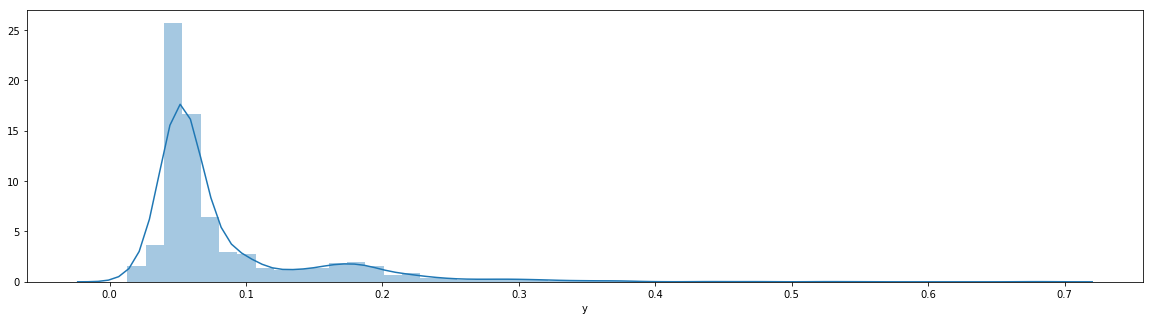

In [64]:
plt.figure(figsize=(20,5))
sns.distplot(df['y'])

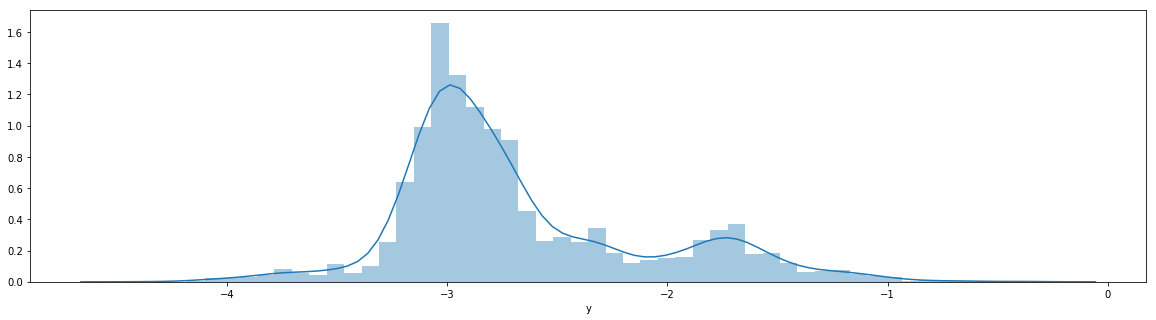

In [702]:
plt.figure(figsize=(20,5))
sns.distplot(np.log(df['y']))

### Border year

In [415]:
def border_year(df,year):
    train = df[df['galactic year']<=year]
    test = df[df['galactic year']>year]
    res = []
    for gal in df['galaxy'].unique():
        f_part = np.mean(train[train['galaxy']==gal]['y'].values)
        s_part = np.mean(test[test['galaxy']==gal]['y'].values)
        if not np.isnan(s_part):
            res.append(abs(s_part-f_part)/f_part)
    return res

In [437]:
b_values = border_year(df_no_nulls, 2000)
print(np.median(b_values))
print(np.mean(b_values))
b_values


0.3823074391340326
0.37676774275468256


[0.36582074952693133,
 0.07203193790741437,
 0.5765029588114438,
 0.5678611380446351,
 1.1983198638327597,
 0.4828122693290578,
 0.4352025332284596,
 0.3365559762220423,
 0.5143742973126546,
 0.6253505217308608,
 0.45525775407416436,
 0.5826858658607688,
 0.5817335296676835,
 0.480918261358405,
 0.0628788568249106,
 0.2038391257852202,
 0.44649261779248967,
 0.07181804598800204,
 0.23448324040638674,
 0.4655582503629018,
 0.5763005311012624,
 0.15398108012074216,
 0.5343189261776762,
 0.4574643384704033,
 0.35930284661617573,
 0.5213235808171047,
 0.3081544758482738,
 0.3527761926911835,
 0.44804990894350427,
 0.31316328095262963,
 0.34041405270415387,
 0.09124502481762084,
 0.41660390328401314,
 0.4416689835132096,
 0.5818186554491934,
 0.4150063943551855,
 0.1952927262795893,
 0.7893007453811041,
 0.15659721756079514,
 0.5100913324311837,
 0.34544719800175805,
 0.4693929007524285,
 0.00036096080591592505,
 0.17567178415686396,
 0.17579334677420844,
 0.45242586616837815,
 0.5069481549

In [440]:
for i in range(15000,25000,1000):
    print(i , np.median(border_year(df_no_nulls, i)))

15000 0.177424834768878
16000 0.19352532589270816
17000 0.2317906008288932
18000 0.23774595152769556
19000 0.2541028659789546
20000 0.2758490457474415
21000 0.3218059168208344
22000 0.35100755664142236
23000 0.3823074391340326
24000 0.36830778677276715


### Correlation

In [44]:
from scipy.stats.stats import pearsonr,spearmanr

corr_arr = {}

for j in df.columns:
    corr_arr[j] = [spearmanr(df[j],df['y'])[0]]


full_corr_df = pd.DataFrame(corr_arr)     
full_corr_df

galactic year    galaxy  existence expectancy index  \
0 -0.196528      -0.063908  0.706762                     

   existence expectancy at birth  Gross income per capita  Income Index  \
0  0.71575                       NaN                      NaN             

   Expected years of education (galactic years)  \
0 NaN                                             

   Mean years of education (galactic years)  \
0 NaN                                         

   Intergalactic Development Index (IDI)  \
0 NaN                                      

   Intergalactic Development Index (IDI), Rank  \
0 NaN                                            

   Population using at least basic drinking-water services (%)  \
0 NaN                                                            

   Population using at least basic sanitation services (%)  \
0 NaN                                                        

   Gross capital formation (% of GGP)  Population, total (millions)  \
0 NaN                                 NaN                             

   Population, urban (%)  \
0 NaN                      

   Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
0 NaN                                                                                 

   Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
0 NaN                                                                     

   Total unemployment rate (female to male ratio)  \
0 NaN                                               

   Unemployment, total (% of labour force)  \
0 NaN                                        

   Labour force participation rate (% ages 15 and older)  \
0 NaN                                                      

   Labour force participation rate (% ages 15 and older), male  \
0 NaN                                                            

   Jungle area (% of total land area)  \
0 NaN                                   

   Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
0 NaN                                                                                        

   Infants lacking immunization, red hot disease (% of one-galactic year-olds)  \
0 NaN                                                                            

   Gross galactic product (GGP), total  \
0 NaN                                    

   Outer Galaxies direct investment, net inflows (% of GGP)  \
0 NaN                                                         

   Exports and imports (% of GGP)  \
0 NaN                               

   Share of seats in senate (% held by female)  Natural resource depletion  \
0 NaN                                          NaN                           

   Maternal mortality ratio (deaths per 100,000 live births)  \
0 NaN                                                          

   Renewable energy consumption (% of total final energy consumption)  \
0 NaN                                                                   

   Domestic credit provided by financial sector (% of GGP)  \
0 NaN                                                        

   Remittances, inflows (% of GGP)  \
0 NaN                                

   Gross enrolment ratio, primary (% of primary under-age population)  \
0 NaN                                                                   

   Respiratory disease incidence (per 100,000 people)  \
0 NaN                                                   

   Interstellar phone subscriptions (per 100 people)  \
0 NaN                                                  

   Interstellar Data Net users, total (% of population)  \
0 NaN                                                     

   Current health expenditure (% of GGP)  Gender Development Index (GDI)  \
0 NaN                                    NaN                               

   Adjusted net savings   \
0 NaN                      

   Creature Immunodeficiency Disease prevalenc

In [45]:
corr_arr = {}

for j in filled_df.columns:
    corr_arr[j] = [spearmanr(filled_df[j],filled_df['y'])[0]]


full_corr_df = pd.DataFrame(corr_arr)     
full_corr_df

galactic year    galaxy  existence expectancy index  \
0 -0.196528      -0.063908  0.706762                     

   existence expectancy at birth  Gross income per capita  Income Index  \
0  0.71575                        0.556172                 0.655119       

   Expected years of education (galactic years)  \
0  0.640982                                       

   Mean years of education (galactic years)  \
0  0.665288                                   

   Intergalactic Development Index (IDI)  \
0  0.733323                                

   Intergalactic Development Index (IDI), Rank  \
0 -0.808903                                      

   Population using at least basic drinking-water services (%)  \
0  0.651676                                                      

   Population using at least basic sanitation services (%)  \
0  0.684941                                                  

   Gross capital formation (% of GGP)  Population, total (millions)  \
0  0.121782                            0.024473                       

   Population, urban (%)  \
0  0.571958                

   Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))  \
0  0.707052                                                                           

   Adolescent birth rate (births per 1,000 female creatures ages 15-19)  \
0 -0.658268                                                               

   Total unemployment rate (female to male ratio)  \
0 -0.038898                                         

   Unemployment, total (% of labour force)  \
0  0.122645                                  

   Labour force participation rate (% ages 15 and older)  \
0 -0.220032                                                

   Labour force participation rate (% ages 15 and older), male  \
0 -0.302947                                                      

   Jungle area (% of total land area)  \
0 -0.013088                             

   Share of employment in nonagriculture, female (% of total employment in nonagriculture)  \
0  0.157119                                                                                  

   Infants lacking immunization, red hot disease (% of one-galactic year-olds)  \
0 -0.397756                                                                      

   Gross galactic product (GGP), total  \
0  0.138919                              

   Outer Galaxies direct investment, net inflows (% of GGP)  \
0  0.088689                                                   

   Exports and imports (% of GGP)  \
0  0.120769                         

   Share of seats in senate (% held by female)  Natural resource depletion  \
0  0.198215                                    -0.352965                     

   Maternal mortality ratio (deaths per 100,000 live births)  \
0 -0.659343                                                    

   Renewable energy consumption (% of total final energy consumption)  \
0 -0.461904                                                             

   Domestic credit provided by financial sector (% of GGP)  \
0  0.537367                                                  

   Remittances, inflows (% of GGP)  \
0 -0.14347                           

   Gross enrolment ratio, primary (% of primary under-age population)  \
0  0.113019                                                             

   Respiratory disease incidence (per 100,000 people)  \
0 -0.54384                                              

   Interstellar phone subscriptions (per 100 people)  \
0  0.447105                                            

   Interstellar Data Net users, total (% of population)  \
0  0.591272                                               

   Current health expenditure (% of GGP)  Gender Development Index (GDI)  \
0  0.321508                               0.514071                         

   Adjusted net savings   \
0  0.210273                

   Creature Immunodeficiency Disease prevalenc

## Categorical features

In [704]:
le = LabelEncoder()
le.fit(full_df['galaxy'])
df_no_nulls['galaxy'] = le.transform(df_no_nulls['galaxy'])
#final_test_df['galaxy'] = le.transform(final_test_df['galaxy'])

ValueError: y contains previously unseen labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180]

In [705]:
df_no_nulls.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 0 to 3610
Data columns (total 43 columns):
galactic year                                                                              3864 non-null int64
galaxy                                                                                     3864 non-null int64
existence expectancy index                                                                 3864 non-null float64
existence expectancy at birth                                                              3864 non-null float64
Gross income per capita                                                                    3864 non-null float64
Income Index                                                                               3864 non-null float64
Expected years of education (galactic years)                                               3864 non-null float64
Mean years of education (galactic years)                                                   3864 non-null f

In [79]:
#final_test_df['galaxy']

In [391]:
np.argwhere(le.classes_=='UGC 8651 (DDO 181)')

array([[163]])

In [49]:
#df[df['galaxy']=='UGC 8651 (DDO 181)']

In [50]:
#df_no_nulls[df_no_nulls['galaxy']==163]

### full df

In [706]:

full_df_no_nulls['galaxy'] = le.transform(full_df_no_nulls['galaxy'])

In [821]:
final_test_df['galaxy'] = le.transform(final_test_df['galaxy'])

In [707]:
full_df_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 0 to 4481
Data columns (total 43 columns):
galactic year                                                                              4754 non-null int64
galaxy                                                                                     4754 non-null int64
existence expectancy index                                                                 4754 non-null float64
existence expectancy at birth                                                              4754 non-null float64
Gross income per capita                                                                    4754 non-null float64
Income Index                                                                               4754 non-null float64
Expected years of education (galactic years)                                               4754 non-null float64
Mean years of education (galactic years)                                                   4754 non-null f

## Train test split

In [775]:
#df_no_nulls_train = df_no_nulls[df_no_nulls['galaxy']==163]
df_no_nulls_train = df_no_nulls.copy()

In [776]:
df_no_nulls_train['year2'] = df_no_nulls_train['galactic year']**2
df_no_nulls_train['year3'] = df_no_nulls_train['galactic year']**3
#df_no_nulls_train['y'] = np.log(df_no_nulls_train['y'])

In [657]:
X = df_no_nulls_train.drop('y',axis=1)
y = df_no_nulls_train['y']
#X_train, X_test, y_train, y_test = train_test_split( X.values, y.values, test_size=0.3, random_state=42)

In [777]:
df_t_train = df_no_nulls_train[(df_no_nulls_train['galactic year']<=17000)].sample(frac=1)  #| (df_no_nulls_train['galactic year'].isin([21030,22036]))

df_t_test = df_no_nulls_train[(df_no_nulls_train['galactic year']>17000)].sample(frac=1)

df_t_train['y'] = np.log(df_t_train['y'])

X_train = df_t_train.drop('y',axis=1).values
y_train = df_t_train['y'].values
X_test = df_t_test.drop('y',axis=1).values
y_test = df_t_test['y'].values

In [743]:
X_train.shape

(3060, 43)

In [717]:
y_train.shape

(3060,)

In [744]:
X_test.shape

(804, 43)

In [708]:
#df_t_train[df_t_train['galaxy']==163]

### full df

In [787]:
pred_train_full_df_no_nulls = full_df_no_nulls.copy()

train_full_df_no_nulls = pred_train_full_df_no_nulls[pred_train_full_df_no_nulls['y']>-1]
test_full_df_no_nulls = pred_train_full_df_no_nulls[pred_train_full_df_no_nulls['y']==-1]


In [788]:
print(train_full_df_no_nulls.shape)
test_full_df_no_nulls.shape

(3864, 43)


(890, 43)

In [791]:
# full_X_train = train_full_df_no_nulls.drop('y',axis=1).values
# full_y_train = train_full_df_no_nulls['y'].values
full_X_test = test_full_df_no_nulls.drop('y',axis=1)

In [713]:
test_full_df_no_nulls

galactic year  galaxy  existence expectancy index  \
4174  17012          96      0.884930                     
4009  18016          96      0.779758                     
4103  19020          96      0.844595                     
4240  20025          96      0.918996                     
4287  21030          96      0.937656                     
4121  22036          96      0.853172                     
4025  25056          96      0.790034                     
4187  26064          96      0.890742                     
4556  22036          33      1.034410                     
4588  23042          33      1.045768                     
4350  25056          33      0.964766                     
4318  26064          33      0.951380                     
3869  23042          177     0.588274                     
3886  24049          177     0.630673                     
3932  26064          177     0.704373                     
3879  22036          162     0.612233                     
3921  23042          162     0.682547                     
3939  17012          90      0.715798                     
3889  18016          90      0.638031                     
3942  19020          90      0.721033                     
3920  20025          90      0.681250                     
3973  21030          90      0.755961                     
4037  23042          67      0.796051                     
4261  24049          67      0.928342                     
4135  22036          170     0.860709                     
4221  23042          170     0.909724                     
4045  23042          27      0.802819                     
4109  24049          27      0.847548                     
4043  26064          27      0.801780                     
3968  17012          8       0.752394                     
4089  18016          8       0.834835                     
4082  19020          8       0.826220                     
3966  20025          8       0.750659                     
4007  21030          8       0.778597                     
4040  22036          8       0.799450                     
3976  23042          8       0.757952                     
3995  24049          8       0.769690                     
4145  22036          25      0.866027                     
4233  23042          25      0.913462                     
4272  24049          25      0.933576                     
4136  25056          25      0.861257                     
4302  26064          25      0.942110                     
3972  25056          77      0.755645                     
4021  26064          77      0.786922                     
4624  17012          101     1.068343                     
4704  18016          101     1.113120                     
4590  19020          101     1.046803                     
4564  20025          101     1.036835                     
4579  21030          101     1.041102                     
4690  17012          40      1.102270                     
4484  18016          40      1.005640                     
4694  19020          40      1.103990                     
4605  20025          40      1.055574                     
4616  21030          40      1.062155                     
4671  22036          40      1.088502                     
4625  23042          40      1.068393                     
4695  24049          40      1.104299                     
4163  23042          51      0.877317                     
4008  24049          51      0.779574                     
4232  17012          144     0.913109                     
4473  18016          144     1.002538                     
4425  19020          144     0.989484                     
4506  20025          144     1.013679                     
4510  21030          144     1.015603                     
4245  22036          144     0.920945                     
4278  25056          144     0.934297                     
4257  17012          38      0.926629                

## Modeling

### GalaxyLinearModelsOnlyYear

In [431]:
class GalaxyLinearModelsOnlyYear():
    def __init__(self,max_border=27000):
        self.models_d = {}
        self.max_border = max_border
        
    def fit(self,X_train):
        
        galaxies = X_train['galaxy'].unique()
        for gal in galaxies:
            x_pl = np.hstack((X_train[X_train['galaxy']==gal]['galactic year'].values.reshape(-1,1)/self.max_border,
                              (X_train[X_train['galaxy']==gal]['galactic year'].values.reshape(-1,1)/self.max_border)**2,
                              (X_train[X_train['galaxy']==gal]['galactic year'].values.reshape(-1,1)/self.max_border)**3))
            #print(x_pl.shape)
            #lr=LinearRegression()
            lr=Ridge()
            lr.fit(x_pl,
                   X_train[X_train['galaxy']==gal]['y'])
            
            self.models_d[gal] = pickle.dumps(lr)
            
    def predict(self,X_test):
        result = []
        for row in X_test.itertuples():
            gal = row.galaxy
            lr = pickle.loads(self.models_d[gal])
            
            x_pl = [[row._1/self.max_border,
                              (row._1/self.max_border)**2,
                              (row._1/self.max_border)**3
                    ]]
            
            result.append(lr.predict(x_pl)[0])
        return result
 

### GalaxyLinearRegrModels

In [725]:
class GalaxyLinearRegrModels():
    def __init__(self,full_df, use_trend_cheat = False):
        self.models_d = {}
        self.cheat = {}
        self.use_trend_cheat = use_trend_cheat
        #self.max_border = max_border
        self.stscaler = StandardScaler().fit(full_df.drop(['galaxy','y'],axis=1))
    
    def fit(self,df_train ):
        
        for gal in df_train['galaxy'].unique():
            
            gal_df = df_train[df_train['galaxy']==gal]
            X_train = gal_df.drop(['galaxy','y'],axis=1)
            X_train = self.stscaler.transform(X_train)
            y_train = gal_df['y'].values
        
            if self.use_trend_cheat:
                pre_trend = gal_df.sort_values('galactic year')['y'].values[-10:]
                trend = pre_trend[1:] - pre_trend[:-1]
                trend[-1] = trend[-1]
                trend = np.sum(trend)
                last_y = gal_df.sort_values('galactic year')['y'].values[-1]
                self.cheat[gal] = (trend,last_y)
            
            #print(x_pl.shape)
            #lr=LinearRegression()
            lr=Ridge(alpha=1)
            lr.fit(X_train,
                   y_train)
            
            self.models_d[gal] = pickle.dumps(lr)
            
    def predict(self,df_test):
        result = []
        for _, row in df_test.iterrows():
            gal = row.galaxy
            lr = pickle.loads(self.models_d[gal])
            
            X_test = row.drop('galaxy').values.reshape(1,-1)
            X_test = self.stscaler.transform(X_test)

            
#             if (gal==10):
#                 print(lr.predict(X_test))
#                 print(self.cheat[gal][0])
#                 print(self.cheat[gal][1])

            pred = lr.predict(X_test)[0]
            
            if self.use_trend_cheat:               
                mean_cheat = np.median(np.abs(list(zip(*self.cheat.values()))[0]))            
                if (row['galactic year'] > 21000) and (abs(self.cheat[gal][0]) >= mean_cheat*0.5):

                    #print(pred)
                    if self.cheat[gal][0]>=0:
                        pred = pred + self.cheat[gal][1]*0.25
                    else:
                        pred = pred - self.cheat[gal][1]*0.25
                    #print(pred) 
                    
            result.append(pred)
            
        return result


In [583]:
np.mean(np.abs(list(zip(*gal_lr_m.cheat.values()))[0]))

0.006249399500616961

In [778]:

gal_lr_m = GalaxyLinearRegrModels(df_no_nulls_train)
gal_lr_m.fit(df_t_train)
gal_lr_m_y_pred = gal_lr_m.predict(df_t_test.drop('y',axis=1))

In [780]:
# if y = log(y)
gal_lr_m_y_pred = np.exp(gal_lr_m_y_pred)

In [781]:
gal_lr_m_y_pred

array([0.04965539, 0.06939704, 0.06189376, 0.04057019, 0.04252543,
       0.03930492, 0.17976927, 0.04029666, 0.04735228, 0.03948252,
       0.31680653, 0.05191285, 0.04470607, 0.20701497, 0.05278333,
       0.04326238, 0.11922557, 0.05489185, 0.12399197, 0.04102887,
       0.04916491, 0.06288295, 0.04834186, 0.06012205, 0.15455826,
       0.3204974 , 0.04405586, 0.03838002, 0.0524701 , 0.04851695,
       0.23192592, 0.12627182, 0.04930081, 0.08826459, 0.06245954,
       0.06022692, 0.03450034, 0.06809628, 0.06400939, 0.05370162,
       0.06775177, 0.05386604, 0.04189086, 0.11075767, 0.06426699,
       0.04483382, 0.03908726, 0.05380271, 0.05652605, 0.06666721,
       0.26995268, 0.04661632, 0.04852137, 0.12034003, 0.0526755 ,
       0.06392334, 0.04298351, 0.03946696, 0.14558624, 0.03394633,
       0.10220383, 0.05725203, 0.19884301, 0.05043309, 0.04031288,
       0.07447835, 0.14223987, 0.15352053, 0.1414848 , 0.12159382,
       0.05199193, 0.05469104, 0.0534385 , 0.37301963, 0.04428

In [756]:
#df_t_test.drop('y',axis=1).values[6,:]

In [719]:
#gal_lr_m.stscaler.transform(df_t_test.drop(['galaxy','y'],axis=1).values[1,:].reshape(1,-1))

In [674]:
print(np.sqrt(mean_squared_error(y_test,gal_lr_m_y_pred))*100)

2.2478367721822696


In [720]:
#df_t_test[['galaxy','er']].groupby('galaxy')['er'].median()

In [274]:
df_t_test[df_t_test['galaxy']==4].sort_values('galactic year')['galactic year']

3780    25056
Name: galactic year, dtype: int64

#### Ploting

In [798]:
def plot_galaxy(gal,df_train,df_test, have_true_y = True):
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=df_train[df_train['galaxy']==gal].sort_values('galactic year')['galactic year']
                 ,y=df_train[df_train['galaxy']==gal].sort_values('galactic year')['y'],
                s=100)
    if have_true_y:
        sns.scatterplot(x=df_test[df_test['galaxy']==gal].sort_values('galactic year')['galactic year'].values,
                     y=df_test[df_test['galaxy']==gal].sort_values('galactic year')['y'].values,
                    s=100,color='red')
        
    sns.scatterplot(x=df_test[df_test['galaxy']==gal].sort_values('galactic year')['galactic year'].values,
                 y=df_test[df_test['galaxy']==gal].sort_values('galactic year')['pred'].values,
                s=100,color='green')


In [669]:
df_graph_test = df_t_test.copy()
df_graph_test['pred'] = gal_lr_m_y_pred
df_graph_test['er'] = np.sqrt((y_test - gal_lr_m_y_pred)**2)

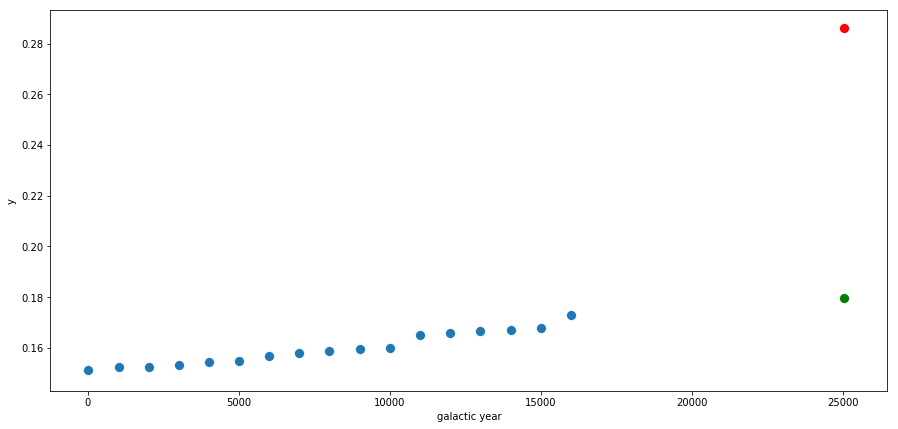

In [670]:
plot_galaxy(4, df_t_train, df_graph_test)

gal 30
gal 31
gal 32
gal 33
gal 34
gal 35
gal 36
gal 37
gal 38
gal 39


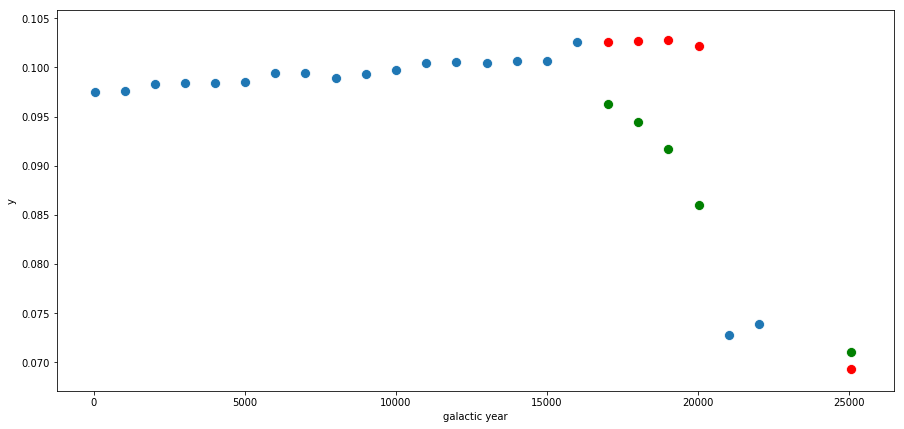

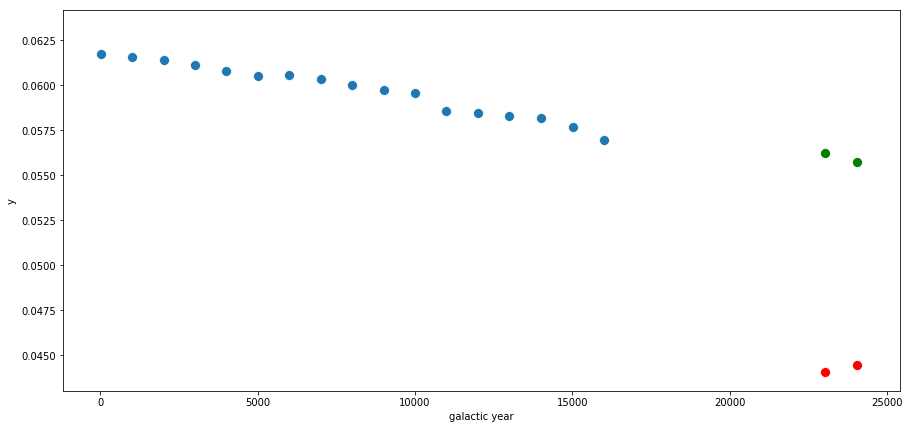

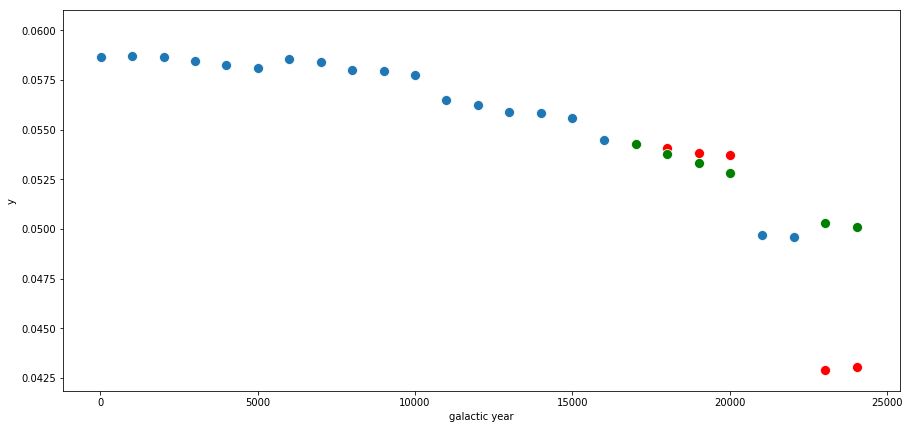

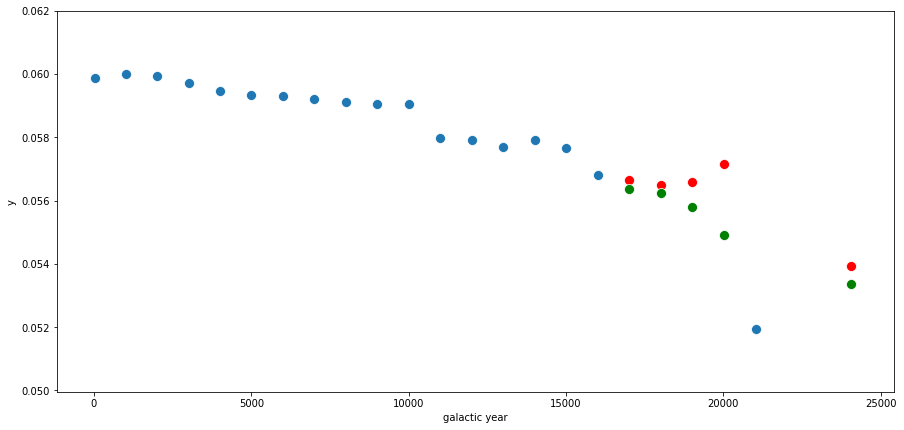

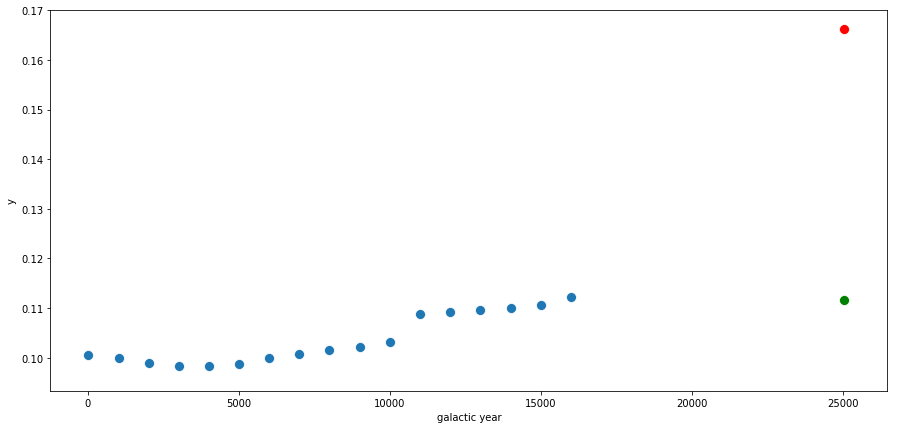

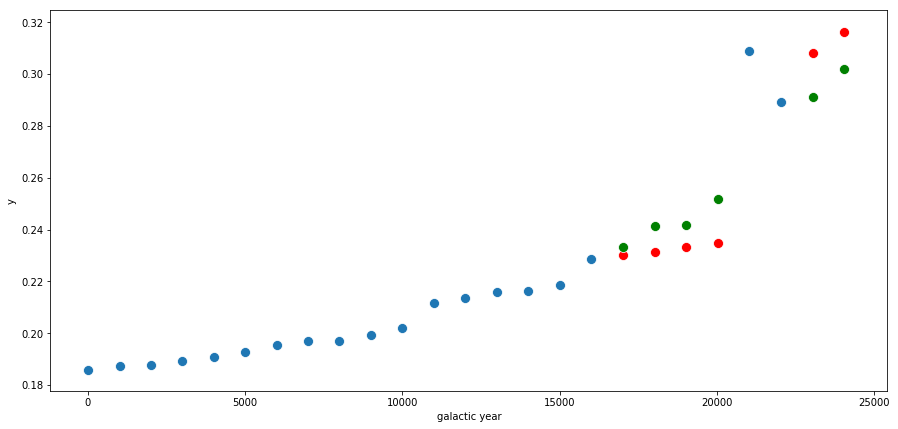

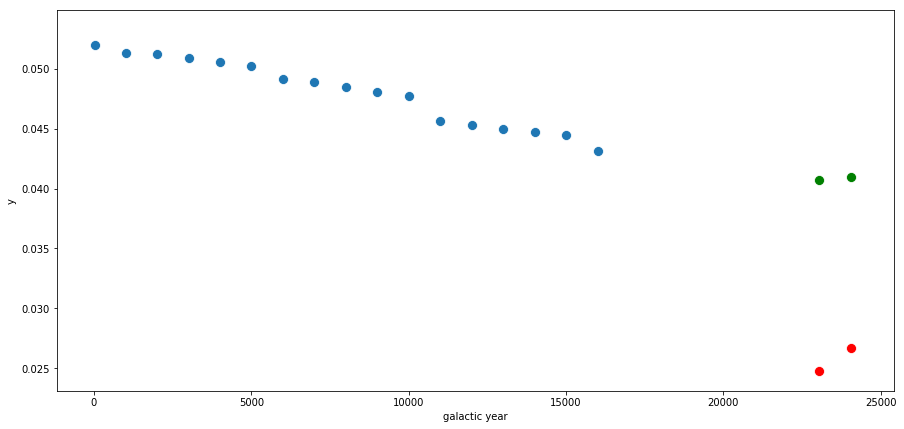

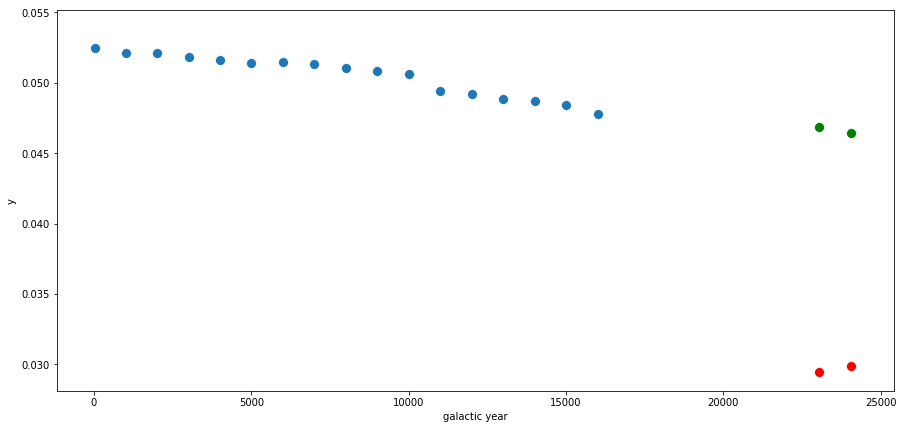

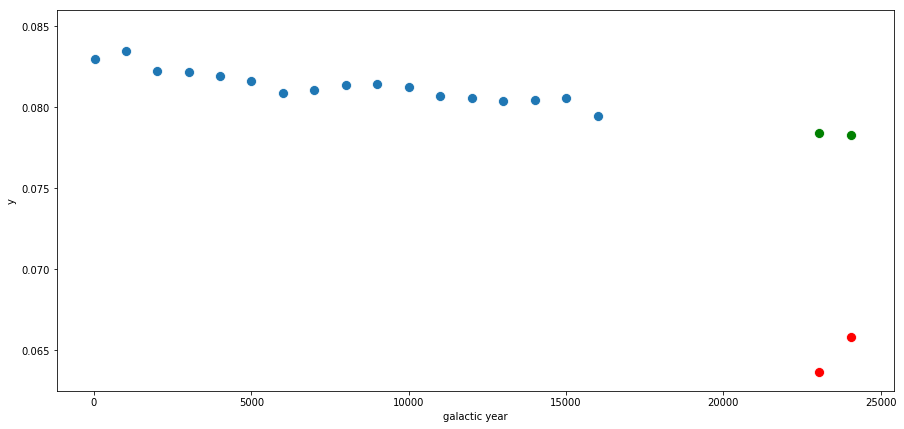

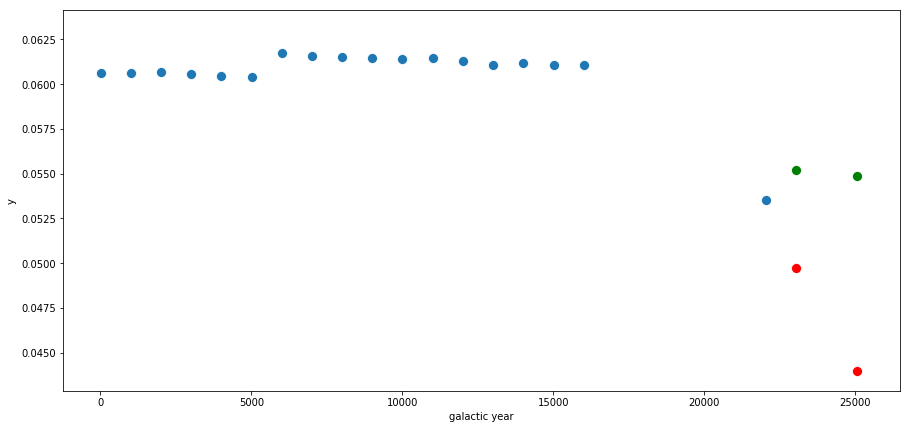

In [671]:
for i in range(30,40):
    print('gal', i)
    plot_galaxy(i, df_t_train, df_graph_test)

In [721]:
#df_t_train[df_t_train['galaxy']==96].sort_values('galactic year')

In [722]:
#df_t_test[df_t_test['galaxy']==54].sort_values('galactic year')

In [723]:
#df_no_nulls_train[df_no_nulls_train['galaxy']==54].sort_values('galactic year')

In [724]:
# np.dot(gal_lr_m.stscaler.transform(df_t_test[df_t_test['galaxy']==4].drop(['galaxy','y'],axis=1).values[:,:])[0],
#       pickle.loads(gal_lr_m.models_d[4]).coef_)

### GalaxyLGBM_Models

In [163]:
class GalaxyLGBM_Models():
    def __init__(self,max_border=27000):
        self.models_d = {}
        self.max_border = max_border
        
    def fit(self,df_train):
        
        for gal in df_train['galaxy'].unique():
            
            gal_df = df_train[df_train['galaxy']==gal]
            X_train = gal_df.drop('y',axis=1).values
            y_train = gal_df['y'].values*100
            
            gal_lgb_model = lgb.LGBMRegressor(
                #objective='binary',
                metric='mse',
            #     class_weight='balanced',
                learning_rate=0.02, 
                n_estimators=100,
                num_leaves=33,
                #is_training_metric=True,
            #   max_depth=5,
                # subsample=0.8,
               # reg_lambda=1.0,
                #boosting='dart',
               min_child_samples=5,
               #scale_pos_weight=np.bincount(y_train)[0]/np.bincount(y_train)[1],
                    n_jobs=-1,
                importance_type='gain'
            )
            gal_lgb_model.fit(
                X_train, y_train,
                #eval_set=[(X_test, y_test)], #,(x_train, y_train)
                eval_metric= ['mse'],
                verbose=50,
                #early_stopping_rounds=50,
               # categorical_feature=[1]

            )
            
            self.models_d[gal] = pickle.dumps(gal_lgb_model)
            
    def predict(self,df_test):
        
        result = []
        #for gal in df_test['galaxy'].unique():
        for _, row in df_test.iterrows():
            gal = row.galaxy    
#             gal_df = df_test[df_test['galaxy']==gal]
#             X_test = gal_df.drop('y',axis=1).values
            X_test = row.values.reshape(1,-1)
            #print(X_test)
            gal_lgb_model = pickle.loads(self.models_d[gal])
            
            result.append(
                gal_lgb_model.predict(X_test)[0]
            )
            
            
        return result
    

In [164]:
#lgb_gal_m.models_d[163]

In [165]:
lgb_gal_m = GalaxyLGBM_Models()
lgb_gal_m.fit(df_t_train)
lgbm_y_pred = lgb_gal_m.predict(df_t_test.drop('y',axis=1))

In [167]:
print(np.sqrt(mean_squared_error(y_test,lgbm_y_pred)))

3.626431867947272


In [144]:
y_test.shape

(804,)

In [148]:
lgbm_y_pred

[7.411860278085327,
 20.201084330034135,
 4.7546477751335265,
 14.68189728783736,
 4.720334201087335,
 3.7608904029538546,
 4.5274188607878125,
 5.817688801282309,
 5.064036637780936,
 21.653180033054703,
 6.376874253205023,
 4.231829188227173,
 6.220572882067123,
 4.245349719484214,
 10.697364903723487,
 30.6257889415353,
 4.652711108961033,
 4.378079737613857,
 3.974198964687393,
 4.81795169408607,
 4.226298589967918,
 10.118941849984202,
 5.912825688950249,
 6.237321258082819,
 21.81313263243612,
 3.745000756822309,
 4.4007067411224865,
 5.692006921138953,
 6.96036307112591,
 5.011530259829941,
 4.678035996285524,
 16.718512419840945,
 4.738502632927187,
 5.025937545392298,
 4.16087439443405,
 4.17103746613286,
 5.5907355006414425,
 5.542170194899025,
 15.624403041398478,
 5.727464964917076,
 6.310231626801847,
 6.6014033280316715,
 4.295825424628954,
 6.3196114591125605,
 18.77513896935686,
 4.802037413823594,
 5.453788376745642,
 19.33828927643516,
 4.798666596081117,
 4.530835945

### CV

In [234]:
X['galactic year'].value_counts().sort_index()

990025     179
991020     178
992016     178
993012     178
994009     178
995006     178
996004     178
997002     178
998001     178
999000     178
1000000    179
1001000    179
1002001    179
1003002    179
1004004    179
1005006    179
1006009    179
1007012    88 
1008016    90 
1009020    90 
1010025    90 
1011030    90 
1012036    90 
1013042    89 
1014049    88 
1015056    87 
Name: galactic year, dtype: int64

In [97]:



folds = [5006,10000,14004,19020]
oof = []
# predictions = np.zeros(len(df_test))
# feature_importance_df = pd.DataFrame()

for fold_, f_year in enumerate(folds):
    print("fold {}".format(fold_))
    
    crval_X_train = X[X['galactic year']<=f_year].sample(frac=1)
    crval_y_train = y.loc[crval_X_train.index].values
    
    crval_X_test = X[X['galactic year']>f_year].sample(frac=1)
    crval_y_test = y.loc[crval_X_test.index].values
    
    crval_X_train = crval_X_train.values
    crval_X_test = crval_X_test.values

    
    crval_model = lgb.LGBMRegressor(
        #objective='binary',
        metric='mse',
    #     class_weight='balanced',
        learning_rate=0.02, 
        n_estimators=50,
        num_leaves=33,
        #is_training_metric=True,
         min_data_in_leaf = 1,
            n_jobs=1,
        importance_type='gain'
    )
    
    crval_model.fit(
        crval_X_train, crval_y_train,
        eval_set=[(crval_X_test, crval_y_test)], #,(x_train, y_train)
        eval_metric= ['mse','rmse'],
        verbose=100,
        early_stopping_rounds=50,
        #categorical_feature=[1]
   
    )
    crval_pred = crval_model.predict(crval_X_test) #, num_iteration=crval_model.best_iteration_)
    print(crval_y_test)
    print('------')
    print(crval_pred)
    oof.append(np.sqrt(mean_squared_error(crval_y_test,crval_pred)))
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["Feature"] = df_train_columns
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
#     predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
print('-------------')
print(np.mean(oof))
oof

fold 0
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1.23655	valid_0's l2: 1.52905
[1.66852521 4.60979801 4.56888868 4.19195828 4.23531108 4.64238656
 4.27341462 3.90672944 4.16546225 4.12575174 4.49961482 4.53334114
 3.79554184 3.82593019 2.05528219 2.83114033 3.86594262 3.76067119]
------
[4.79151039 4.79151039 4.79151039 4.79151039 4.79151039 4.79151039
 4.79151039 4.79151039 4.79151039 4.79151039 4.79151039 4.79151039
 4.77248022 4.79151039 4.77248022 4.77248022 4.79151039 4.79151039]
fold 1
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1.28617	valid_0's l2: 1.65423
[4.16546225 2.05528219 3.90672944 3.86594262 4.23531108 4.19195828
 3.82593019 3.79554184 1.66852521 4.27341462 2.83114033 3.76067119
 4.12575174]
------
[4.57625871 4.57625871 4.586733   4.586733   4.57625871 4.57625871
 4.57625871 4.57625871 4.58722856 

[1.2365495242759015, 1.2861688191180016, 1.411372919806355, 1.8772541466050945]

In [240]:
model.best_iteration_

79

['4.150', '2.694', '3.045', '4.295']

### VAlid

In [159]:


model = lgb.LGBMRegressor(
    #objective='binary',
    metric='mse',
#     class_weight='balanced',
    learning_rate=0.02, 
    n_estimators=1000,
    num_leaves=93,
    #is_training_metric=True,
#   max_depth=5,
    # subsample=0.8,
   # reg_lambda=1.0,
    #boosting='dart',
    min_child_samples=5,
   #scale_pos_weight=np.bincount(y_train)[0]/np.bincount(y_train)[1],
        n_jobs=-1,
    importance_type='gain'
)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], #,(x_train, y_train)
    eval_metric= ['mse'],
    verbose=50,

#     eval_metric = [
#         'auc', 
#     ],
#     eval_metric = [
#         'auc', 
#         'binary_logloss',
#     ],

   early_stopping_rounds=50,
   # categorical_feature=[1]

)
   

Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 32.6779
[100]	valid_0's l2: 22.5051
[150]	valid_0's l2: 19.5925
[200]	valid_0's l2: 18.49
[250]	valid_0's l2: 18.0411
[300]	valid_0's l2: 17.8825
[350]	valid_0's l2: 17.8263
[400]	valid_0's l2: 17.7988
[450]	valid_0's l2: 17.782
[500]	valid_0's l2: 17.7687
[550]	valid_0's l2: 17.7678
Early stopping, best iteration is:
[529]	valid_0's l2: 17.7659


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='gain', learning_rate=0.02, max_depth=-1,
       metric='mse', min_child_samples=5, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=93,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [86]:
y_train

array([3.90672944, 4.49961482, 4.74174873, 4.84291156, 4.19195828,
       4.53334114, 4.77167837, 4.85323682, 4.60979801, 4.93942484,
       4.23531108, 4.56888868, 4.27341462, 4.8078178 , 4.12575174,
       4.64238656, 4.16546225])

### Combining

In [432]:
gm = GalaxyModels()
gm.fit(df_t_train)

In [409]:
set(df_t_train.galaxy.unique()).difference(set(df_t_test.galaxy.unique()))
set(df_t_test.galaxy.unique()).difference(set(df_t_train.galaxy.unique()))

set()

In [430]:
np.mean(np.hstack((model.predict(X_test).reshape(-1,1),np.array(gm.predict(df_t_test)).reshape(-1,1))),axis=1)

array([ 3.97630589,  5.67305357,  3.98992044,  4.18268213, 18.26986771,
       15.92587817,  4.95864942,  6.4232666 ,  5.15344214, 10.20795733,
        5.93278204,  3.97259162, 13.12434395,  7.38752385,  9.90649214,
        4.09466916, 16.6988211 ,  6.04976198,  3.89972957,  6.25361582,
        4.29933555,  4.82147384,  5.85076804,  4.1144028 ,  4.90922414,
        5.31038606,  4.36540734,  4.02717495,  4.21691595,  6.86540448,
        5.37833934, 21.95423858,  3.74571102,  4.28831556,  3.88198507,
        3.52036756,  5.75708876,  4.4695833 ,  5.44924661,  3.79526281,
        4.27099971,  6.33387333,  5.21066986, 19.09697929, 35.55501813,
        5.23211301,  3.77416123,  5.21069307,  3.92999308,  6.43446056,
       10.20397906,  7.38718168,  4.72040443,  3.85916801, 28.45993932,
        5.21601877,  9.71178063,  4.92017895, 21.9966819 , 15.4738321 ,
       16.40081016,  3.79108397,  9.32315993,  4.21184804,  5.51148474,
        3.79178658, 12.83350035,  4.95505301,  5.71851362,  3.84

In [429]:
np.hstack((model.predict(X_test).reshape(-1,1),np.array(gm.predict(df_t_test)).reshape(-1,1)))

array([[ 4.14855773,  3.80405405],
       [ 5.74505928,  5.60104786],
       [ 3.95630525,  4.02353563],
       ...,
       [ 3.99777325,  3.86602862],
       [ 3.91301591,  3.24394377],
       [ 8.43036575, 10.28449724]])

In [443]:
print(np.sqrt(mean_squared_error(y_test,np.mean(np.hstack((model.predict(X_test).reshape(-1,1),np.array(gm.predict(df_t_test)).reshape(-1,1))),axis=1))))

4.051642527087809


In [437]:
print(np.sqrt(mean_squared_error(y_test,gm.predict(df_t_test))))

3.254414492263409


### Results

In [782]:
#y_pred_val = model.predict(X_test)
y_pred_val = gal_lr_m_y_pred
print(np.sqrt(mean_squared_error(y_test,y_pred_val))*100)
print(np.sqrt(mean_squared_error(y_test,y_pred_val))/df['y'].describe()['std'], "%")

3.157345308437054
0.4978422719366428 %


In [783]:
r2_score(y_test,y_pred_val)

0.872920357589857

In [162]:
pd.DataFrame(model.feature_importances_/1000,
             index=X.columns).sort_values(0)



0
Gross galactic product (GGP), total                                                      0.795943   
Unemployment, total (% of labour force)                                                  1.114369   
Remittances, inflows (% of GGP)                                                          1.672601   
Income Index                                                                             1.990967   
Interstellar phone subscriptions (per 100 people)                                        2.071273   
Population, total (millions)                                                             2.196994   
Gross capital formation (% of GGP)                                                       2.197613   
Population using at least basic drinking-water services (%)                              2.231979   
Gross enrolment ratio, primary (% of primary under-age population)                       2.296560   
Expected years of education (galactic years)                                             2.450472   
Share of employment in nonagriculture, female (% of total employment in nonagriculture)  2.463508   
Labour force participation rate (% ages 15 and older), male                              2.532354   
existence expectancy at birth                                                            2.918942   
Adjusted net savings                                                                     3.712651   
Private galaxy capital flows (% of GGP)                                                  4.338326   
Infants lacking immunization, red hot disease (% of one-galactic year-olds)              4.588262   
Labour force participation rate (% ages 15 and older)                                    4.693006   
Total unemployment rate (female to male ratio)                                           5.082223   
Intergalactic Development Index (IDI)                                                    5.292340   
galactic year                                                                            5.889782   
Outer Galaxies direct investment, net inflows (% of GGP)                                 5.918933   
Gender Development Index (GDI)                                                           6.175228   
Maternal mortality ratio (deaths per 100,000 live births)                                6.785842   
Current health expenditure (% of GGP)                                                    7.159203   
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total                7.995263   
Population, urban (%)                                                                    8.531222   
existence expectancy index                                                               8.872484   
Mean years of education (galactic years)                                                 10.954211  
Natural resource depletion                                                               15.523406  
galaxy                                                                                   18.850863  
Intergalactic Development Index (IDI), Rank                                              19.001514  
Share of seats in senate (% held by female)                                              23.692614  
Respiratory disease incidence (per 100,000 people)                                       25.946587  
Adolescent birth rate (births per 1,000 female creatures ages 15-19)                     28.206426  
Interstellar Data Net users, total (% of population)                                     28.930984  
Population using at least basic sanitation services (%)                                  36.414794  
Exports and imports (% of GGP)                                                           53.045131  
Domestic credit provided by financial sector (% of GGP)                                  64.155987  
Jungle area (% of total land area)                                                       67.973418  
Renewable energy consumption (% of total final energy consu

## Saving results

In [730]:
class Save_metrics():
    def __init__(self,path):
        self.path_ = path
        
    def load(self):
        if not os.path.exists(self.path_):
            print('No file')
        else:
            return pd.read_json(self.path_)
    
    def save(self, metrics, name):
        df = None
        if os.path.exists(self.path_):
            df = self.load()
            if name not in df.index:
                df.loc[name] = metrics
            else:
                print('Dubled name')
        else:
            df = pd.DataFrame(metrics,index = [name])
        
        df.to_json(self.path_)
        
    def replace(self, df):
        if df.empty:
            print('No df')
        else:
            df.to_json(self.path_)

In [731]:
mertic_file = Save_metrics('metrics')

In [784]:


metrics_dict = {
                'CV rmse': 0,  #f'{np.mean(oof):.4f}',
                'CV folds': 0,  #f'{[f"{i:.3f}" for i in oof]}',
                'Val rmse':f'{np.sqrt(mean_squared_error(y_test,y_pred_val))*100:.3f}',
                'Val r2':f'{r2_score(y_test,y_pred_val):.3f}',

               }

mertic_file.save(metrics_dict,
                 f'galaxy lin regr models log(y) +y**2+y**3')

In [785]:
mertic_file.load()

CV rmse  \
baseline                                  3.5461    
galaxy lin regr models                    0.0000    
galaxy lin regr models +y**2              0.0000    
galaxy lin regr models +y**2+y**3         0.0000    
galaxy lin regr models log(y) +y**2+y**3  0.0000    

                                                                      CV folds  \
baseline                                  ['4.150', '2.694', '3.045', '4.295']   
galaxy lin regr models                    0                                      
galaxy lin regr models +y**2              0                                      
galaxy lin regr models +y**2+y**3         0                                      
galaxy lin regr models log(y) +y**2+y**3  0                                      

                                          Val rmse  Val r2  
baseline                                  3.530     0.840   
galaxy lin regr models                    3.328     0.859   
galaxy lin regr models +y**2              3.226     0.867   
galaxy lin regr models +y**2+y**3         3.169     0.872   
galaxy lin regr models log(y) +y**2+y**3  3.157     0.873

In [736]:
# s = mertic_file.load()
# mertic_file.replace(s.iloc[:-1,:])

# s['margin'] = [5,5,10]


## Final prediction

### Lgbm

In [51]:

fin_model = lgb.LGBMRegressor(
    #objective='binary',
    metric='mse',
#     class_weight='balanced',
    learning_rate=0.05, 
    n_estimators=1000,
    num_leaves=33,
#   max_depth=5,
    # subsample=0.8,
   # reg_lambda=1.0,
    #boosting='dart',
   # min_child_samples=1000,
   #scale_pos_weight=np.bincount(y_train)[0]/np.bincount(y_train)[1],
        n_jobs=-1,
    importance_type='gain'
)
fin_model.fit(
    X.values, y.values,

    verbose=50,

#     eval_metric = [
#         'auc', 
#     ],
#     eval_metric = [
#         'auc', 
#         'binary_logloss',
#     ],

   # early_stopping_rounds=50,
    categorical_feature=[0,1]
#     categorical_feature=['host_same']
)
   

/Users/dmitriy/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1]



LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='gain', learning_rate=0.05, max_depth=-1,
       metric='mse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=33,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [52]:
fin_y_pred = fin_model.predict(final_test_df.values)/100

### Galaxy lin regr models

In [792]:
gal_lr_m = GalaxyLinearRegrModels(pred_train_full_df_no_nulls)
gal_lr_m.fit(train_full_df_no_nulls)
gal_lr_m_y_pred = gal_lr_m.predict(full_X_test)

In [793]:
gal_lr_m_y_pred

[0.04508360951023179,
 0.044055441126039374,
 0.04323987883273401,
 0.03917944000742798,
 0.036945155036138225,
 0.03153661744381456,
 0.03145135028776468,
 0.03238705157671752,
 0.054710106385629086,
 0.05479905705557526,
 0.054030100570966605,
 0.054243092959998955,
 0.026016220387537408,
 0.02674341338702041,
 0.026742291464130694,
 0.024782633032881845,
 0.026350824131654408,
 0.039485926601063565,
 0.03919695170812184,
 0.03770312183714322,
 0.03709155205056562,
 0.031561039553041514,
 0.040550189217047394,
 0.0316929292574352,
 0.04980630942722907,
 0.042239384277147074,
 0.03509839470170748,
 0.028002792460838907,
 0.035230767935771255,
 0.0375266581102963,
 0.036612111629325525,
 0.037512706912891866,
 0.0361105845122971,
 0.02997942153299995,
 0.028567184813427786,
 0.028208104084248037,
 0.02576784449051704,
 0.052625772429701366,
 0.05640844901075218,
 0.057044146074797325,
 0.056603005405214936,
 0.05986173524754067,
 0.02287393290358016,
 0.028921087169648904,
 0.224830781

In [796]:
predicted_full_X_test = full_X_test.copy()
predicted_full_X_test['pred'] = gal_lr_m_y_pred

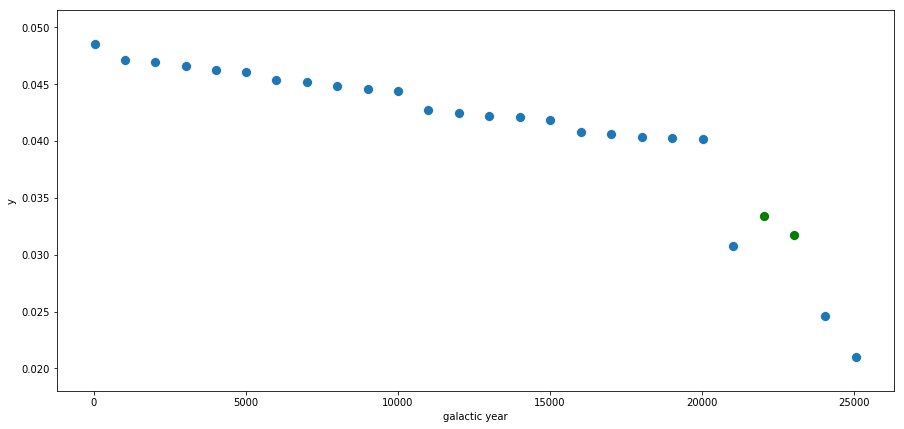

In [812]:
plot_galaxy(165, train_full_df_no_nulls, predicted_full_X_test, False)

## Load csv

In [901]:
subm = pd.read_csv('sample_submit.csv',index_col='index')

In [828]:
final_csv_pred = pd.merge(
    final_test_df[['galactic year','galaxy']],
    predicted_full_X_test[['galactic year','galaxy','pred']],
         on=['galactic year','galaxy']
        )

In [902]:
subm['pred']=final_csv_pred['pred']


In [903]:
subm

pred  opt_pred
index                    
0      0.041039  100     
1      0.036832  100     
2      0.036481  100     
3      0.037567  100     
4      0.026016  100     
5      0.040169  100     
6      0.029637  100     
7      0.040542  100     
8      0.037090  100     
9      0.039061  100     
10     0.037594  100     
11     0.026900  100     
12     0.040183  100     
13     0.038649  100     
14     0.024783  100     
15     0.030975  100     
16     0.027837  100     
17     0.028253  100     
18     0.034601  100     
19     0.036323  100     
20     0.034239  100     
21     0.026743  100     
22     0.036568  100     
23     0.039541  100     
24     0.039197  100     
25     0.025487  100     
26     0.024184  100     
27     0.031892  100     
28     0.039553  100     
29     0.035090  100     
30     0.038271  100     
31     0.039324  100     
32     0.040499  100     
33     0.052909  100     
34     0.024917  100     
35     0.037718  100     
36     0.041432  100     
37     0.027969  100     
38     0.029391  100     
39     0.035770  100     
40     0.037879  100     
41     0.024040  100     
42     0.034688  100     
43     0.036880  100     
44     0.051321  100     
45     0.033123  100     
46     0.035173  100     
47     0.030905  100     
48     0.038860  100     
49     0.017875  100     
50     0.038986  100     
51     0.038541  100     
52     0.030746  100     
53     0.033856  100     
54     0.031894  100     
55     0.037092  100     
56     0.026351  100     
57     0.023464  100     
58     0.039179  100     
59     0.036805  100     
60     0.029736  100     
61     0.043244  100     
62     0.037664  100     
63     0.035986  100     
64     0.040053  100     
65     0.032455  100     
66     0.037718  100     
67     0.026742  100     
68     0.039881  100     
69     0.043332  100     
70     0.043335  100     
71     0.034154  100     
72     0.040891  100     
73     0.026324  100     
74     0.039486  100     
75     0.043319  100     
76     0.024959  100     
77     0.037703  100     
78     0.031747  100     
79     0.027446  100     
80     0.040751  100     
81     0.044015  100     
82     0.041308  100     
83     0.026784  100     
84     0.018126  100     
85     0.038844  100     
86     0.039033  100     
87     0.032702  100     
88     0.021203  100     
89     0.043055  100     
90     0.039481  100     
91     0.028231  100     
92     0.025498  100     
93     0.033591  100     
94     0.037083  100     
95     0.045646  100     
96     0.033411  100     
97     0.032656  100     
98     0.028403  100     
99     0.027420  100     
100    0.040672  80      
101    0.036111  80      
102    0.026621  80      
103    0.037527  80      
104    0.038483  80      
105    0.038303  80      
106    0.026789  80      
107    0.022874  80      
108    0.031561  80      
109    0.033829  80      
110    0.031794  80      
111    0.028208  80      
112    0.028058  80      
113    0.040349  80      
114    0.044686  80      
115    0.027574  80      
116    0.040272  80      
117    0.046078  80      
118    0.032431  80      
119    0.023916  80      
120    0.039602  80      
121    0.040377  80      
122    0.026351  80      
123    0.027081  80      
124    0.037368  80      
125    0.030956  80      
126    0.025557  80      
127    0.040350  80      
128    0.026554  80      
129    0.036920  80      
130    0.025768  80      
131    0.042942  80      
132    0.041631  80      
133    0.039080  80      
134    0.043158  80      
135    0.028194  80      
136    0.025510  80      
137    0.040714  80      
138    0.018486  80      
139    0.045718  80      
140    0.044370  80      
141    0.023660  80      
142    0.029979  80      
143    0.028475  80      
144    0.044055  80      
145    0.040285  80      
146    0.041253  80      
147    0.028460  80      
148    0.035038  80      
149    0.038282  80      
150    0.038860  80      
151    0.071080  80      
152    

## Allocating energy

In [182]:
final_test_df[final_test_df['existence expectancy index']<0.7].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
           dtype='int64')

In [56]:
subm['p_ind'] = -np.log(subm['pred']+0.01)+3
subm['m_l_inc'] =  subm['p_ind']**2 / 1000

In [57]:
subm['p_ind'].describe()

count    890.000000
mean     5.626383  
std      0.607083  
min      3.701091  
25%      5.352491  
50%      5.819120  
75%      6.017951  
max      6.766203  
Name: p_ind, dtype: float64

### MAx likely increase analysing

In [58]:
subm['m_l_inc'] =  subm['p_ind']**2 / 1000

In [59]:
subm['m_l_inc'].describe()

count    890.000000
mean     0.032024  
std      0.006483  
min      0.013698  
25%      0.028649  
50%      0.033862  
75%      0.036216  
max      0.045781  
Name: m_l_inc, dtype: float64

In [236]:
subm['m_l_inc'].sum()

2850.613928695145

In [234]:
50000/subm['p_ind'].sum()

9.984100416118872

In [77]:
max_energy = 50000
l_inc_arr = []
ratio_arr = np.linspace(0.1,0.7,60)

for ratio in ratio_arr:
    f_part = ratio*max_energy
    s_part = max_energy-f_part
    f_unit = f_part/subm['m_l_inc'].loc[:65].sum()
    s_unit = s_part/subm['m_l_inc'].loc[66:].sum()
    
    l_inc_arr.append(
        ((subm['m_l_inc'].loc[:65] * f_unit) * subm['m_l_inc'].loc[:65]).sum() + ((subm['m_l_inc'].loc[66:] * s_unit) * subm['m_l_inc'].loc[66:]).sum()
    )

In [80]:
#l_inc_arr

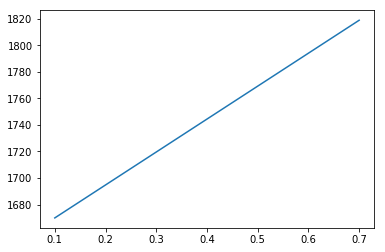

In [79]:
sns.lineplot(y=l_inc_arr, x=ratio_arr)

### First 100 then proportional

In [831]:
subm['p_ind'] = -np.log(subm['pred']+0.01)+3
subm['m_l_inc'] =  subm['p_ind']**2 / 1000

In [832]:
subm['opt_pred'].loc[:65] = 100
s_part = 50000-6600-0.001
s_unit = s_part/subm['m_l_inc'].loc[66:].sum()
subm['opt_pred'].loc[66:] = subm['m_l_inc'].loc[66:] * s_unit

In [833]:
subm

pred    opt_pred     p_ind   m_l_inc
index                                          
0      0.041039  100.000000  5.975155  0.035702
1      0.036832  100.000000  6.061182  0.036738
2      0.036481  100.000000  6.068710  0.036829
3      0.037567  100.000000  6.045622  0.036550
4      0.026016  100.000000  6.323786  0.039990
5      0.040169  100.000000  5.992357  0.035908
6      0.029637  100.000000  6.227984  0.038788
7      0.040542  100.000000  5.984949  0.035820
8      0.037090  100.000000  6.055698  0.036671
9      0.039061  100.000000  6.014696  0.036177
10     0.037594  100.000000  6.045055  0.036543
11     0.026900  100.000000  6.299556  0.039684
12     0.040183  100.000000  5.992074  0.035905
13     0.038649  100.000000  6.023124  0.036278
14     0.024783  100.000000  6.358637  0.040432
15     0.030975  100.000000  6.194799  0.038376
16     0.027837  100.000000  6.274481  0.039369
17     0.028253  100.000000  6.263528  0.039232
18     0.034601  100.000000  6.110008  0.037332
19     0.036323  100.000000  6.072123  0.036871
20     0.034239  100.000000  6.118148  0.037432
21     0.026743  100.000000  6.303796  0.039738
22     0.036568  100.000000  6.066845  0.036807
23     0.039541  100.000000  6.004949  0.036059
24     0.039197  100.000000  6.011924  0.036143
25     0.025487  100.000000  6.338583  0.040178
26     0.024184  100.000000  6.376001  0.040653
27     0.031892  100.000000  6.172663  0.038102
28     0.039553  100.000000  6.004720  0.036057
29     0.035090  100.000000  6.099104  0.037199
30     0.038271  100.000000  6.030933  0.036372
31     0.039324  100.000000  6.009350  0.036112
32     0.040499  100.000000  5.985807  0.035830
33     0.052909  100.000000  5.766066  0.033248
34     0.024917  100.000000  6.354792  0.040383
35     0.037718  100.000000  6.042446  0.036511
36     0.041432  100.000000  5.967494  0.035611
37     0.027969  100.000000  6.270983  0.039325
38     0.029391  100.000000  6.234218  0.038865
39     0.035770  100.000000  6.084135  0.037017
40     0.037879  100.000000  6.039081  0.036470
41     0.024040  100.000000  6.380221  0.040707
42     0.034688  100.000000  6.108054  0.037308
43     0.036880  100.000000  6.060156  0.036725
44     0.051321  100.000000  5.791636  0.033543
45     0.033123  100.000000  6.143705  0.037745
46     0.035173  100.000000  6.097245  0.037176
47     0.030905  100.000000  6.196507  0.038397
48     0.038860  100.000000  6.018793  0.036226
49     0.017875  100.000000  6.580008  0.043297
50     0.038986  100.000000  6.016212  0.036195
51     0.038541  100.000000  6.025351  0.036305
52     0.030746  100.000000  6.200404  0.038445
53     0.033856  100.000000  6.126853  0.037538
54     0.031894  100.000000  6.172611  0.038101
55     0.037092  100.000000  6.055662  0.036671
56     0.026351  100.000000  6.314538  0.039873
57     0.023464  100.000000  6.397289  0.040925
58     0.039179  100.000000  6.012283  0.036148
59     0.036805  100.000000  6.061771  0.036745
60     0.029736  100.000000  6.225485  0.038757
61     0.043244  100.000000  5.932864  0.035199
62     0.037664  100.000000  6.043583  0.036525
63     0.035986  100.000000  6.079429  0.036959
64     0.040053  100.000000  5.994665  0.035936
65     0.032455  100.000000  6.159315  0.037937
66     0.037718  61.175841   6.042451  0.036511
67     0.026742  66.582825   6.303827  0.039738
68     0.039881  60.281382   5.998115  0.035977
69     0.043332  58.944396   5.931225  0.035179
70     0.043335  58.943161   5.931163  0.035179
71     0.034154  62.757800   6.120079  0.037455
72     0.040891  59.879315   5.978078  0.035737
73     0.026324  66.824849   6.315273  0.039883
74     0.039486  60.441329   6.006067  0.036073
75     0.043319  58.949207   5.931467  0.035182
76     0.024959  67.638184   6.353589  0.040368
77     0.037703  61.182065   6.042758  0.036515
78     0.031747  63.912455   6.176123  0.038144
79     0.027446  66.182419   6.284844  0.039499
80     0.040751  59.934434   5.980829  0.035770
81     0.044015  58.691582 

### First 100 then percent of confidence

In [ ]:
def fill_in_confident(percent):
    len_other = subm['m_l_inc'].loc[66:].shape[0]
    border = np.ceil(percent*len_other).astype(int)
    sorted_subm = subm['m_l_inc'].loc[66:].sort_values()
    zero_indxs = sorted_subm.iloc[:border].index
    hundred_indxs = sorted_subm.iloc[-border:].index
    left_indxs = sorted_subm.iloc[border:-border].index

    return zero_indxs,hundred_indxs,left_indxs

In [841]:
subm['p_ind'] = -np.log(subm['pred']+0.01)+3
subm['m_l_inc'] =  subm['p_ind']**2 / 1000

In [871]:
subm['opt_pred'].iloc[:65] = 100
s_part = 50000-6600-0.001

zero_indxs,hundred_indxs,left_indxs = fill_in_confident(0.2)

subm['opt_pred'].iloc[zero_indxs] = 0
subm['opt_pred'].iloc[hundred_indxs] = 100
t_part = s_part-subm['opt_pred'].iloc[hundred_indxs].sum()

left_unit = t_part/subm['m_l_inc'].iloc[left_indxs].sum()
subm['opt_pred'].iloc[left_indxs] = subm['m_l_inc'].iloc[left_indxs] * left_unit

In [870]:
t_part

26899.999000000003

In [872]:
left_indxs.shape[0]+zero_indxs.shape[0]+hundred_indxs.shape[0]

824

### percent of confidence

In [883]:
def fill_in_confident(percent):
    len_other = subm['m_l_inc'].shape[0]
    border = np.ceil(percent*len_other).astype(int)
    sorted_subm = subm['m_l_inc'].sort_values()
    zero_indxs = sorted_subm.iloc[:border].index
    hundred_indxs = sorted_subm.iloc[-border:].index
    left_indxs = sorted_subm.iloc[border:-border].index

    return zero_indxs,hundred_indxs,left_indxs

In [904]:
subm['p_ind'] = -np.log(subm['pred']+0.01)+3
subm['m_l_inc'] =  subm['p_ind']**2 / 1000

In [905]:
s_part = 50000-0.001

zero_indxs, hundred_indxs, left_indxs = fill_in_confident(0.4)

subm['opt_pred'].iloc[zero_indxs] = 0
subm['opt_pred'].iloc[hundred_indxs] = 100
t_part = s_part-subm['opt_pred'].iloc[hundred_indxs].sum()

left_unit = t_part/subm['m_l_inc'].iloc[left_indxs].sum()
subm['opt_pred'].iloc[left_indxs] = subm['m_l_inc'].iloc[left_indxs] * left_unit

### go from min

In [218]:
subm['p_ind'].loc[:65].max()

6.790363587370335

In [205]:
poor_m = 100/subm['p_ind'].loc[:65].max()

In [219]:
rich_all_en = 50000-0.01-subm['p_ind'].loc[:65].sum()*poor_m

In [220]:
rich_m = rich_all_en/subm['p_ind'].loc[66:].sum()

In [222]:
print(poor_m)
rich_m

14.726751920323375


9.567027656745047

In [221]:
subm['opt_pred'].loc[:65] = subm['p_ind'].loc[:65] * poor_m
subm['opt_pred'].loc[66:] = subm['p_ind'].loc[66:] * rich_m

### Testing

In [ ]:
-np.log(Index+0.01)+3

In [132]:
-np.log(0.057+0.01)+3

5.703062659591171

In [136]:
-np.log(0.08+0.01)+3

5.407945608651872

In [137]:
-np.log(0.02+0.01)+3

6.506557897319982

In [139]:
100*(5.7**2)/1000

3.249

In [144]:
6.5/6.5**2*1000

153.84615384615387

In [146]:
1000/5.7


175.43859649122805

/Users/dmitriy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [151]:
subm['max_e'] = 1000/subm['p_ind']

In [161]:
subm['opt_pred'] = 50000/subm['p_ind'].sum()*subm['p_ind']

In [154]:
np.exp(0.029525)*1000/(0.029525**2)

1181524.5012209401

In [160]:
subm['opt_e'].max()

67.7956719182626

In [82]:
subm

pred    opt_pred     p_ind   m_l_inc
index                                          
0      0.041988  100.000000  5.956747  0.035483
1      0.038844  100.000000  6.019115  0.036230
2      0.038965  100.000000  6.016656  0.036200
3      0.038563  100.000000  6.024903  0.036299
4      0.021802  100.000000  6.448231  0.041580
5      0.028519  100.000000  6.256607  0.039145
6      0.027453  100.000000  6.284665  0.039497
7      0.041099  100.000000  5.973998  0.035689
8      0.040922  100.000000  5.977464  0.035730
9      0.040104  100.000000  5.993653  0.035924
10     0.038285  100.000000  6.030635  0.036369
11     0.021177  100.000000  6.468085  0.041836
12     0.041020  100.000000  5.975534  0.035707
13     0.040674  100.000000  5.982349  0.035788
14     0.030552  100.000000  6.205182  0.038504
15     0.039387  100.000000  6.008074  0.036097
16     0.018031  100.000000  6.574438  0.043223
17     0.029632  100.000000  6.228120  0.038789
18     0.038319  100.000000  6.029933  0.036360
19     0.038636  100.000000  6.023395  0.036281
20     0.037738  100.000000  6.042034  0.036506
21     0.022079  100.000000  6.439544  0.041468
22     0.036639  100.000000  6.065310  0.036788
23     0.015859  100.000000  6.655090  0.044290
24     0.041519  100.000000  5.965808  0.035591
25     0.020935  100.000000  6.475863  0.041937
26     0.028104  100.000000  6.267423  0.039281
27     0.037167  100.000000  6.054069  0.036652
28     0.041131  100.000000  5.973355  0.035681
29     0.031316  100.000000  6.186507  0.038273
30     0.040531  100.000000  5.985164  0.035822
31     0.038880  100.000000  6.018383  0.036221
32     0.041525  100.000000  5.965686  0.035589
33     0.055090  100.000000  5.731988  0.032856
34     0.015951  100.000000  6.651527  0.044243
35     0.038712  100.000000  6.021823  0.036262
36     0.041996  100.000000  5.956594  0.035481
37     0.037439  100.000000  6.048303  0.036582
38     0.021266  100.000000  6.465222  0.041799
39     0.032023  100.000000  6.169531  0.038063
40     0.039759  100.000000  6.000561  0.036007
41     0.042541  100.000000  5.946161  0.035357
42     0.039300  100.000000  6.009827  0.036118
43     0.040578  100.000000  5.984242  0.035811
44     0.054573  100.000000  5.739955  0.032947
45     0.028164  100.000000  6.265865  0.039261
46     0.038669  100.000000  6.022721  0.036273
47     0.028738  100.000000  6.250934  0.039074
48     0.037564  100.000000  6.045674  0.036550
49     0.013140  100.000000  6.766203  0.045781
50     0.039545  100.000000  6.004879  0.036059
51     0.040468  100.000000  5.986410  0.035837
52     0.021519  100.000000  6.457168  0.041695
53     0.038412  100.000000  6.028013  0.036337
54     0.020345  100.000000  6.495134  0.042187
55     0.041407  100.000000  5.967986  0.035617
56     0.021088  100.000000  6.470949  0.041873
57     0.044338  100.000000  5.912525  0.034958
58     0.031894  100.000000  6.172610  0.038101
59     0.040032  100.000000  5.995087  0.035941
60     0.030478  100.000000  6.207008  0.038527
61     0.045453  100.000000  5.892217  0.034718
62     0.029246  100.000000  6.237899  0.038911
63     0.039842  100.000000  5.998903  0.035987
64     0.029108  100.000000  6.241420  0.038955
65     0.036032  100.000000  6.078429  0.036947
66     0.039582  60.138527   6.004118  0.036049
67     0.042862  58.862262   5.940067  0.035284
68     0.042549  58.979955   5.946002  0.035355
69     0.043875  58.486659   5.921084  0.035059
70     0.046014  57.720217   5.882160  0.034600
71     0.039673  60.101870   6.002288  0.036027
72     0.021222  69.760431   6.466621  0.041817
73     0.030819  64.097797   6.198611  0.038423
74     0.042462  59.012834   5.947659  0.035375
75     0.045535  57.888792   5.890743  0.034701
76     0.029573  64.740367   6.229604  0.038808
77     0.041953  59.206454   5.957408  0.035491
78     0.030918  64.047640   6.196185  0.038393
79     0.031399  63.806125   6.184492  0.038248
80     0.043000  58.810523   5.937455  0.035253
81     0.044680  58.194119 

## Save csv

In [907]:
subm = subm[['pred','opt_pred']]

In [908]:
subm['opt_pred'].sum()

49999.999

In [909]:
subm['opt_pred'].iloc[:65].sum()

6459.853848559704

In [910]:
subm.to_csv('results/13_06_gallnrmodels_all_confident_40_opt.csv',header=True,sep=',')

In [175]:
5000/66

75.75757575757575

In [906]:
subm

pred    opt_pred     p_ind   m_l_inc
index                                          
0      0.041039  100.000000  5.975155  0.035702
1      0.036832  100.000000  6.061182  0.036738
2      0.036481  100.000000  6.068710  0.036829
3      0.037567  100.000000  6.045622  0.036550
4      0.026016  100.000000  6.323786  0.039990
5      0.040169  100.000000  5.992357  0.035908
6      0.029637  100.000000  6.227984  0.038788
7      0.040542  100.000000  5.984949  0.035820
8      0.037090  100.000000  6.055698  0.036671
9      0.039061  100.000000  6.014696  0.036177
10     0.037594  100.000000  6.045055  0.036543
11     0.026900  100.000000  6.299556  0.039684
12     0.040183  100.000000  5.992074  0.035905
13     0.038649  100.000000  6.023124  0.036278
14     0.024783  100.000000  6.358637  0.040432
15     0.030975  100.000000  6.194799  0.038376
16     0.027837  100.000000  6.274481  0.039369
17     0.028253  100.000000  6.263528  0.039232
18     0.034601  100.000000  6.110008  0.037332
19     0.036323  100.000000  6.072123  0.036871
20     0.034239  100.000000  6.118148  0.037432
21     0.026743  100.000000  6.303796  0.039738
22     0.036568  100.000000  6.066845  0.036807
23     0.039541  100.000000  6.004949  0.036059
24     0.039197  100.000000  6.011924  0.036143
25     0.025487  100.000000  6.338583  0.040178
26     0.024184  100.000000  6.376001  0.040653
27     0.031892  100.000000  6.172663  0.038102
28     0.039553  100.000000  6.004720  0.036057
29     0.035090  100.000000  6.099104  0.037199
30     0.038271  100.000000  6.030933  0.036372
31     0.039324  100.000000  6.009350  0.036112
32     0.040499  100.000000  5.985807  0.035830
33     0.052909  79.573267   5.766066  0.033248
34     0.024917  100.000000  6.354792  0.040383
35     0.037718  100.000000  6.042446  0.036511
36     0.041432  100.000000  5.967494  0.035611
37     0.027969  100.000000  6.270983  0.039325
38     0.029391  100.000000  6.234218  0.038865
39     0.035770  100.000000  6.084135  0.037017
40     0.037879  100.000000  6.039081  0.036470
41     0.024040  100.000000  6.380221  0.040707
42     0.034688  100.000000  6.108054  0.037308
43     0.036880  100.000000  6.060156  0.036725
44     0.051321  80.280582   5.791636  0.033543
45     0.033123  100.000000  6.143705  0.037745
46     0.035173  100.000000  6.097245  0.037176
47     0.030905  100.000000  6.196507  0.038397
48     0.038860  100.000000  6.018793  0.036226
49     0.017875  100.000000  6.580008  0.043297
50     0.038986  100.000000  6.016212  0.036195
51     0.038541  100.000000  6.025351  0.036305
52     0.030746  100.000000  6.200404  0.038445
53     0.033856  100.000000  6.126853  0.037538
54     0.031894  100.000000  6.172611  0.038101
55     0.037092  100.000000  6.055662  0.036671
56     0.026351  100.000000  6.314538  0.039873
57     0.023464  100.000000  6.397289  0.040925
58     0.039179  100.000000  6.012283  0.036148
59     0.036805  100.000000  6.061771  0.036745
60     0.029736  100.000000  6.225485  0.038757
61     0.043244  100.000000  5.932864  0.035199
62     0.037664  100.000000  6.043583  0.036525
63     0.035986  100.000000  6.079429  0.036959
64     0.040053  100.000000  5.994665  0.035936
65     0.032455  100.000000  6.159315  0.037937
66     0.037718  100.000000  6.042451  0.036511
67     0.026742  100.000000  6.303827  0.039738
68     0.039881  100.000000  5.998115  0.035977
69     0.043332  100.000000  5.931225  0.035179
70     0.043335  100.000000  5.931163  0.035179
71     0.034154  100.000000  6.120079  0.037455
72     0.040891  100.000000  5.978078  0.035737
73     0.026324  100.000000  6.315273  0.039883
74     0.039486  100.000000  6.006067  0.036073
75     0.043319  100.000000  5.931467  0.035182
76     0.024959  100.000000  6.353589  0.040368
77     0.037703  100.000000  6.042758  0.036515
78     0.031747  100.000000  6.176123  0.038144
79     0.027446  100.000000  6.284844  0.039499
80     0.040751  100.000000  5.980829  0.035770
81     0.044015  83.835911 